In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
!pip install plotly
import plotly.io as pio

pio.renderers.default = 'iframe_connected'

In [3]:
## collab user
# !pip install neuron
#!pip install netpyne
# !git clone https://github.com/suny-downstate-medical-center/S1_netpyne.git  # NEW UPDATES AND MORE DETAILS
# !git clone https://github.com/suny-downstate-medical-center/S1_Thal_NetPyNE_Frontiers_2022
# import os
# os.chdir('S1_Thal_NetPyNE_Frontiers_2022/runSubNets')

In [4]:
import matplotlib
import os
os.chdir('../sim')

In [5]:
# !nrnivmodl -coreneuron mod/
!nrnivmodl mod/

/opt/conda/bin/nrnivmodl:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
/opt/workspace/S1_Thal_NetPyNE_Frontiers_2022/main/sim
Mod files: "mod/ar_traub.mod" "mod/cadad.mod" "mod/CaDynamics_E2.mod" "mod/cadyn.mod" "mod/cagk.mod" "mod/Ca_HVA.mod" "mod/cal_mh.mod" "mod/cal_mig.mod" "mod/Ca_LVAst.mod" "mod/Ca.mod" "mod/cancr.mod" "mod/canin.mod" "mod/can_mig.mod" "mod/catcb.mod" "mod/cat_mig.mod" "mod/cat_traub.mod" "mod/ch_CavL.mod" "mod/ch_CavN.mod" "mod/ch_KCaS.mod" "mod/ch_Kdrfastngf.mod" "mod/ch_KvAngf.mod" "mod/ch_KvCaB.mod" "mod/ch_leak.mod" "mod/ch_Navngf.mod" "mod/DetAMPANMDA.mod" "mod/DetGABAAB.mod" "mod/gabab.mod" "mod/h_BS.mod" "mod/HCN1.mod" "mod/HH2.mod" "mod/h_harnett.mod" "mod/hin.mod" "mod/h_kole.mod" "mod/h_migliore.mod" "mod/htc.mod" "mod/ican_sidi.mod" "mod/iccr.mod" "mod/IC.mod" "mod/iconc_Ca.mod" "mod/Ih.mod" "mod/ikscr.mod" "mod/IKsin.mod" "mod/Im.mod" 

In [6]:
"""
cfg.py 

Simulation configuration for S1 model (using NetPyNE)
This file has sim configs as well as specification for parameterized values in netParams.py 

Contributors: salvadordura@gmail.com, fernandodasilvaborges@gmail.com
"""

from neuron import h, gui
from neuron import rxd
from netpyne import specs, sim
import pickle, json
import numpy as np

# should go after importing netpyne
import matplotlib
%matplotlib inline

cfg = specs.SimConfig()  

#------------------------------------------------------------------------------
#
# SIMULATION CONFIGURATION
#
#------------------------------------------------------------------------------

cfg.simType='run_subNets'
cfg.coreneuron = False

#------------------------------------------------------------------------------
# Run parameters
#------------------------------------------------------------------------------
cfg.cai_secs =1e-12
cfg.duration = 0.2*1e3 ## Duration of the sim, in ms  
cfg.dt = 0.1 #OG =0.025
cfg.seeds = {'conn': 4321, 'stim': 4321, 'loc': 4321} 
cfg.hParams = {'celsius': 34, 'v_init': -63}  
cfg.verbose = False
cfg.createNEURONObj = True
cfg.createPyStruct = True  
cfg.cvode_active = False
cfg.cvode_atol = 1e-6
cfg.cache_efficient = True
cfg.printRunTime = 0.1

cfg.includeParamsLabel = True
cfg.printPopAvgRates = True

cfg.checkErrors = True

# S1 pop
cfg.poptypeNumber = 55 # m-types
cfg.celltypeNumber = 207 # me-types

cfg.rootFolder = os.getcwd()

--No graphics will be displayed.


In [7]:
#------------------------------------------------------------------------------
# Saving
#------------------------------------------------------------------------------
cfg.simLabel = 'L5_ImPhysX5_Cai1e-12_Sk0'
cfg.saveFolder = '../runSubNets/'+cfg.simLabel
cfg.savePickle = False         	## Save pkl file
cfg.saveJson = True	           	## Save json file
cfg.saveDataInclude = ['simData'] ## , 'netParams', 'simConfig', ,'simData'
cfg.backupCfgFile = None
cfg.gatherOnlySimData = False
cfg.saveCellSecs = False
cfg.saveCellConns = True

In [8]:
cfg.use_frac = {} # use[invivo] = cfg.use_frac * use[invitro]

cfg.use_frac['EIproximal'] = 0.75 # shallow dependence between PC-proximal targeting cell types (LBCs, NBCs, SBCs, ChC)
cfg.use_frac['Inh'] = 0.50 # Pathways that had not been studied experimentally were assumed to have an intermediate level of dependence
cfg.use_frac['EE'] = 0.25 # steep Ca2+ dependence for connections between PC-PC and PC-distal targeting cell types (DBC, BTC, MC, BP)
cfg.use_frac['EIdistal'] = 0.25 


In [9]:
#------------------------------------------------------------------------------  
# S1 Cells
# Load 55 Morphological Names and Cell pop numbers -> L1:6 L23:10 L4:12 L5:13 L6:14
# Load 207 Morpho-electrical Names used to import the cells from 'cell_data/' -> L1:14 L23:43 L4:46 L5:52 L6:52
# Create [Morphological,Electrical] = number of cell metype in the sub-pop

with open('cells/S1-cells-distributions-Rat.txt') as mtype_file:
    mtype_content = mtype_file.read()       

cfg.popNumber = {}
cfg.cellNumber = {} 
cfg.popLabel = {} 
popParam = []
cellParam = []
cfg.meParamLabels = {} 
cfg.popLabelEl = {} 
cfg.cellLabel = {}

for line in mtype_content.split('\n')[:-1]:
    cellname, mtype, etype, n, m = line.split()
    metype = mtype + '_' + etype[0:3]
    cfg.cellNumber[metype] = int(n)
    cfg.popLabel[metype] = mtype
    cfg.popNumber[mtype] = int(m)
    cfg.cellLabel[metype] = cellname

    if mtype not in popParam:
        popParam.append(mtype)
        cfg.popLabelEl[mtype] = [] 
               
    cfg.popLabelEl[mtype].append(metype)
    
    cellParam.append(mtype + '_' + etype[0:3])
    
cfg.S1pops = popParam
cfg.S1cells = cellParam

cfg.popParamLabels = popParam
cfg.cellParamLabels = cellParam

#------------------------------------------------------------------------------  
# number=0
# for mtype in cfg.S1pops:
#     for cellEl in range(np.size(cfg.popLabelEl[mtype])):
#         number+=1
#         print(number,cfg.popLabelEl[mtype][cellEl], cfg.popLabel[cfg.popLabelEl[mtype][cellEl]], popLabelEl[cfg.popLabelEl[mtype][cellEl]])

In [10]:
#------------------------------------------------------------------------------
# Cells
#------------------------------------------------------------------------------
# TO DEBUG - import and simulate only the Cell soma (to study only the Net)
cfg.reducedtest = False    

# TO DEBUG - Create only 5 Cells for each MEtype in S1
cfg.oneCellperMEtypeS1 = True

In [11]:
#------------------------------------------------------------------------------  
# TO DEBUG - Create only one Cell per MEtype in S1 cells
if cfg.oneCellperMEtypeS1:
	cfg.popNumber = {}
	cfg.cellNumber = {} 
	for mtype in cfg.S1pops:
		cfg.popNumber[mtype] = 0

	for line in mtype_content.split('\n')[:-1]:
		cellname, mtype, etype, n, m = line.split()
		metype = mtype + '_' + etype[0:3]
		if int(n) < 5:
			cfg.cellNumber[metype] = int(n)
			cfg.popNumber[mtype] = cfg.popNumber[mtype] + int(n)
		else:
			cfg.cellNumber[metype] = 50
			cfg.popNumber[mtype] = cfg.popNumber[mtype] + 50


In [12]:
cfg.S1pops = popParam
cfg.S1cells = cellParam

cfg.popParamLabels = popParam
cfg.cellParamLabels = cellParam

## Run only selected populations (me-types)

In [13]:
#Wricha added this section
selected_indices = [28, 29, 30, 31, 32, 33, 34, 35]
#L2/3: 6, 7, 8, 9, 10, 11, 12, 13, 14 
#L4: 16, 17, 18, 19, 20, 21, 22, 23
#L5: 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39

# Check if any index is out of range
invalid_indices = [i for i in selected_indices if i >= len(cfg.S1pops)]
if invalid_indices:
    print(f"Error: Indices {invalid_indices} are out of range for cfg.S1pops.")
else:
    # Include specific cell populations based on indices
    subPopLabels = [cfg.S1pops[i] for i in selected_indices]

    # Print information for all subpopulations
for subPopLabel in subPopLabels:
    print(f"\nInformation for Subpopulation: {subPopLabel}")


# subPopLabels = cfg.S1pops[25] # from 0 to 55 is full S1 -> L1:6 L23:10 L4:12 L5:13 L6:14
# ------------------------------------------------------------------------------
#cfg.S1pops = subPopLabels
cfg.S1cells = []
for metype in cfg.cellParamLabels:
    if cfg.popLabel[metype] in subPopLabels:        
        cfg.S1cells.append(metype)
        
cfg.thalamicpops = []

cfg.popParamLabels = cfg.S1pops
cfg.cellParamLabels = cfg.S1cells

cfg.cellNumber[metype]
cfg.popNumber[cfg.popLabel[metype]]
#------------------------------------------------------------------------------  
for metype in cfg.cellParamLabels:
    print(metype,cfg.cellNumber[metype],cfg.popLabel[metype],cfg.popNumber[cfg.popLabel[metype]])   
 


Information for Subpopulation: L5_BP

Information for Subpopulation: L5_BTC

Information for Subpopulation: L5_ChC

Information for Subpopulation: L5_DBC

Information for Subpopulation: L5_LBC

Information for Subpopulation: L5_MC

Information for Subpopulation: L5_NBC

Information for Subpopulation: L5_NGC
L5_BP_bAC 3 L5_BP 206
L5_BP_bIR 50 L5_BP 206
L5_BP_bNA 50 L5_BP 206
L5_BP_cAC 50 L5_BP 206
L5_BP_cNA 50 L5_BP 206
L5_BP_dST 3 L5_BP 206
L5_BTC_bAC 50 L5_BTC 150
L5_BTC_cAC 50 L5_BTC 150
L5_BTC_cNA 50 L5_BTC 150
L5_ChC_cAC 50 L5_ChC 150
L5_ChC_cNA 50 L5_ChC 150
L5_ChC_dNA 50 L5_ChC 150
L5_DBC_bAC 50 L5_DBC 350
L5_DBC_bIR 50 L5_DBC 350
L5_DBC_bNA 50 L5_DBC 350
L5_DBC_bST 50 L5_DBC 350
L5_DBC_cAC 50 L5_DBC 350
L5_DBC_cIR 50 L5_DBC 350
L5_DBC_cNA 50 L5_DBC 350
L5_LBC_bAC 50 L5_LBC 350
L5_LBC_cAC 50 L5_LBC 350
L5_LBC_cIR 50 L5_LBC 350
L5_LBC_cNA 50 L5_LBC 350
L5_LBC_cST 50 L5_LBC 350
L5_LBC_dNA 50 L5_LBC 350
L5_LBC_dST 50 L5_LBC 350
L5_MC_bAC 50 L5_MC 350
L5_MC_bIR 50 L5_MC 350
L5_MC_bS

In [14]:
# #------------------------------------------------------------------------------  
# # # Change popNumber
# # ------------------------------------------------------------------------------  
# cfg.cellNumber[metype] = 10
# cfg.popNumber[cfg.popLabel[metype]] = 10
# #------------------------------------------------------------------------------  
# for metype in cfg.cellParamLabels:
#     print(metype,cfg.cellNumber[metype],cfg.popLabel[metype],cfg.popNumber[cfg.popLabel[metype]])  

In [15]:
#------------------------------------------------------------------------------  
# Thalamic Cells

cfg.thalamicpops = ['ss_RTN_o', 'ss_RTN_m', 'ss_RTN_i', 'VPL_sTC', 'VPM_sTC', 'POm_sTC_s1']

cfg.cellNumber['ss_RTN_o'] = int(382 * (210**2/150**2)) # from mouse model (d = 150 um)
cfg.cellNumber['ss_RTN_m'] = int(382 * (210**2/150**2))
cfg.cellNumber['ss_RTN_i'] = int(765 * (210**2/150**2))
cfg.cellNumber['VPL_sTC'] = int(656 * (210**2/150**2))
cfg.cellNumber['VPM_sTC'] = int(839 * (210**2/150**2))
cfg.cellNumber['POm_sTC_s1'] = int(685 * (210**2/150**2))

for mtype in cfg.thalamicpops: # No diversity
	metype = mtype
	cfg.popLabel[metype] = mtype
	cfg.popNumber[mtype] = cfg.cellNumber[metype]

In [16]:
for idx, popLabel in enumerate(cfg.S1pops, start=0):
    try:
        popNumber = cfg.popNumber[popLabel]
        print(f"Line {idx}: Population Label: {popLabel}, Population Number: {popNumber}")
    except KeyError:
        print(f"Line {idx}: Population Label: {popLabel} does not exist in cfg.popNumber")

Line 0: Population Label: L1_DAC, Population Number: 100
Line 1: Population Label: L1_DLAC, Population Number: 50
Line 2: Population Label: L1_HAC, Population Number: 150
Line 3: Population Label: L1_NGC-DA, Population Number: 200
Line 4: Population Label: L1_NGC-SA, Population Number: 50
Line 5: Population Label: L1_SLAC, Population Number: 150
Line 6: Population Label: L23_BP, Population Number: 114
Line 7: Population Label: L23_BTC, Population Number: 250
Line 8: Population Label: L23_ChC, Population Number: 150
Line 9: Population Label: L23_DBC, Population Number: 200
Line 10: Population Label: L23_LBC, Population Number: 300
Line 11: Population Label: L23_MC, Population Number: 250
Line 12: Population Label: L23_NBC, Population Number: 300
Line 13: Population Label: L23_NGC, Population Number: 200
Line 14: Population Label: L23_PC, Population Number: 50
Line 15: Population Label: L23_SBC, Population Number: 150
Line 16: Population Label: L4_BP, Population Number: 8
Line 17: Popula

In [17]:
# for idx, popLabel in enumerate(cfg.S1pops, start=0):
#     try:
#         popNumber = cfg.popNumber[popLabel]
#         print(f"Line {idx}: Population Label: {popLabel}, Population Number: {popNumber}")
#     except KeyError:
#         print(f"Line {idx}: Population Label: {popLabel} does not exist in cfg.popNumber")

In [18]:
#--------------------------------------------------------------------------
# Recording 
#--------------------------------------------------------------------------
cfg.allpops = cfg.cellParamLabels
cfg.cellsrec = 3
if cfg.cellsrec == 0:  cfg.recordCells = cfg.allpops # record all cells
elif cfg.cellsrec == 1: cfg.recordCells = [(pop,0) for pop in cfg.allpops] # record one cell of each pop
elif cfg.cellsrec == 2: # record one cell of each cellMEtype
    cfg.recordCells = []
    for metype in cfg.cellParamLabels:
        if cfg.cellNumber[metype] < 5:
            for numberME in range(cfg.cellNumber[metype]):
                cfg.recordCells.append((metype,numberME))
        else:
            numberME = 0
            diference = cfg.cellNumber[metype] - 5.0*int(cfg.cellNumber[metype]/5.0)
            
            for number in range(5):            
                cfg.recordCells.append((metype,numberME))
                
                if number < diference:              
                    numberME+=int(np.ceil(cfg.cellNumber[metype]/5.0))  
                else:
                    numberME+=int(cfg.cellNumber[metype]/5.0)
                
        
cfg.recordTraces = {'V_soma': {'sec':'soma', 'loc':0.5, 'var':'v'},
                   'cai_soma': {'sec': 'soma', 'loc':0.5, 'var': 'cai'},
                   'cao_soma': {'sec': 'soma', 'loc': 0.5, 'var': 'cao'}}  ## Dict with traces to record
cfg.recordStim = True
cfg.recordTime = False
cfg.recordStep = 0.2    

In [19]:
"""
netParams.py
"""
# Network parameters
netParams = specs.NetParams()  # object of class NetParams to store the network parameters

netParams.scale = 1.0 # Scale factor for number of cells
netParams.sizeX = 420.0 # x-dimension (horizontal length) size in um
netParams.sizeY = 2082.0 # y-dimension (vertical height or cortical depth) size in um
netParams.sizeZ = 420.0 # z-dimension (horizontal depth) size in um
netParams.shape = 'cylinder' # cylindrical (column-like) volume

# r = 210 um and hexagonal side length = 230.9 um

In [20]:
# # ------------------------------------------------------------------------------
# # General network parameters
# # ------------------------------------------------------------------------------
# # Layer	height (um)	height (norma)	from	to
# # L1	165		    0.079		    0.000	0.079
# # L2	149		    0.072		    0.079	0.151
# # L3	353		    0.170		    0.151	0.320
# # L4	190		    0.091		    0.320	0.412
# # L5	525		    0.252		    0.412	0.664
# # L6	700		    0.336		    0.664	1.000
# # L23	502		    0.241		    0.079	0.320
# # All	2082	    1.000	

# # ORIGINAL 
# cellModels = ['HH_full']
# Epops = ['L23_PC', 'L4_PC', 'L4_SS', 'L4_SP', 
#              'L5_TTPC1', 'L5_TTPC2', 'L5_STPC', 'L5_UTPC',
#              'L6_TPC_L1', 'L6_TPC_L4', 'L6_BPC', 'L6_IPC', 'L6_UTPC']
# Ipops = []
# for popName in cfg.S1pops:
#     if popName not in Epops:
#         Ipops.append(popName)

# Epops = []
# for popName in cfg.S1pops:
#     if popName not in Ipops:
#         Epops.append(popName)   

# layer = {'1':[0.0, 0.079], '2': [0.079,0.151], '3': [0.151,0.320], '23': [0.079,0.320], '4':[0.320,0.412], '5': [0.412,0.664], '6': [0.664,1.0], 
# 'longS1': [2.2,2.3], 'longS2': [2.3,2.4]}  # normalized layer boundaries


In [21]:
# Define the existing cell models and population groups
#OG Musc Pops :MuscPops = ['L23_PC', 'L4_PC', 'L4_SS', 'L4_SP',  'L23_NGC', 'L23_DBC', 'L23_BP', 'L23_MC', 'L23_BTC',  'L23_ChC',  
            # 'L4_NGC', 'L4_DBC', 'L4_BP', 'L4_MC', 'L4_BTC',  'L4_ChC',
            # 'L5_TTPC1', 'L5_TTPC2', 'L5_STPC', 'L5_UTPC', 'L5_NGC', 'L5_DBC', 'L5_BP', 'L5_MC', 'L5_BTC',  'L5_ChC',
            # 'L6_TPC_L1', 'L6_TPC_L4', 'L6_BPC', 'L6_IPC', 'L6_UTPC']
            # from Paul et al, 2017,Fusik et al, 2016  

            #last run on 13/04/2024
            # MuscPops = ['L23_PC', 'L4_PC', 'L4_SS', 'L4_SP', 'L23_DBC', 'L23_BP', 'L23_MC',  'L23_ChC',  
            # 'L4_DBC', 'L4_BP', 'L4_MC',  'L4_ChC',
            # 'L5_TTPC1', 'L5_TTPC2', 'L5_STPC', 'L5_UTPC', 'L5_DBC', 'L5_BP', 'L5_MC',  'L5_ChC',
            # 'L6_TPC_L1', 'L6_TPC_L4', 'L6_BPC', 'L6_IPC', 'L6_UTPC']


cellModels = ['HH_full']
Epops = ['L23_PC', 'L4_PC', 'L4_SS', 'L4_SP',
         'L5_TTPC1', 'L5_TTPC2', 'L5_STPC', 'L5_UTPC',
         'L6_TPC_L1', 'L6_TPC_L4', 'L6_BPC', 'L6_IPC', 'L6_UTPC']

# # # Define the new population groups MuscPops and Ipops
# MIPops = ['L23_LBC', 'L23_NBC', 'L23_SBC', 'L23_BTC'
#          'L4_LBC', 'L4_NBC', 'L4_SBC', 'L4_BTC', 'L4_MC'
#          'L5_LBC', 'L5_NBC', 'L5_SBC', 'L5_BTC' , 'L5_MC']

MIPops = ['L23_LBC', 'L23_NBC',
         'L4_LBC', 'L4_NBC', 
         'L5_LBC', 'L5_NBC']


MuscPops = ['L23_BP', 'L23_BTC', 'L23_ChC', 'L23_DBC', 'L23_MC', 'L23_NGC', 
            'L4_BP', 'L4_BTC', 'L4_ChC', 'L4_DBC',   'L4_MC', 'L4_NGC', 
            'L5_BP', 'L5_BTC', 'L5_ChC', 'L5_DBC',  'L5_MC', 'L5_NGC' ]

Ipops = ['L23_BP', 'L23_BTC', 'L23_ChC', 'L23_DBC', 'L23_LBC', 'L23_NBC', 'L23_MC', 'L23_NGC', 'L23_SBC',
        'L4_BP', 'L4_BTC', 'L4_ChC', 'L4_DBC', 'L4_LBC', 'L4_NBC', 'L4_MC', 'L4_NGC', 'L4_SBC',
        'L5_BP', 'L5_BTC', 'L5_ChC', 'L5_DBC', 'L5_LBC', 'L5_NBC', 'L5_MC', 'L5_NGC', 'L5_SBC']

# # Filter the populations based on MuscPops and Ipops
# for popName in cfg.S1pops:
#     if any(cellType in popName for cellType in MuscPops):
#         MuscPops.append(popName)
#     elif popName not in Epops:
#         Ipops.append(popName)

# for popName in cfg.S1pops:
#     if popName not in Epops:
#         Ipops.append(popName)

for popName in cfg.S1pops:
    if popName in MuscPops:
        MuscPops.append(popName)

# for popName in cfg.S1pops:
#     if popName in MIPops:
#         MIPops.append(popName)   

layer = {'1':[0.0, 0.079], '2': [0.079,0.151], '3': [0.151,0.320], '23': [0.079,0.320], '4':[0.320,0.412], '5': [0.412,0.664], '6': [0.664,1.0], 
'longS1': [2.2,2.3], 'longS2': [2.3,2.4]}  # normalized layer boundaries

In [22]:
# Line 0: Population Label: L1_DAC, Population Number: 58
# Line 1: Population Label: L1_DLAC, Population Number: 24
# Line 2: Population Label: L1_HAC, Population Number: 91
# Line 3: Population Label: L1_NGC-DA, Population Number: 72
# Line 4: Population Label: L1_NGC-SA, Population Number: 52
# Line 5: Population Label: L1_SLAC, Population Number: 41
# Line 6: Population Label: L23_BP, Population Number: 28
# Line 7: Population Label: L23_BTC, Population Number: 104
# Line 8: Population Label: L23_ChC, Population Number: 61
# Line 9: Population Label: L23_DBC, Population Number: 175
# Line 10: Population Label: L23_LBC, Population Number: 456
# Line 11: Population Label: L23_MC, Population Number: 333
# Line 12: Population Label: L23_NBC, Population Number: 268
# Line 13: Population Label: L23_NGC, Population Number: 56
# Line 14: Population Label: L23_PC, Population Number: 5877
# Line 15: Population Label: L23_SBC, Population Number: 166
# Line 16: Population Label: L4_BP, Population Number: 8
# Line 17: Population Label: L4_BTC, Population Number: 20
# Line 18: Population Label: L4_ChC, Population Number: 8
# Line 19: Population Label: L4_DBC, Population Number: 40
# Line 20: Population Label: L4_LBC, Population Number: 122
# Line 21: Population Label: L4_MC, Population Number: 118
# Line 22: Population Label: L4_NBC, Population Number: 96
# Line 23: Population Label: L4_NGC, Population Number: 6
# Line 24: Population Label: L4_PC, Population Number: 2674
# Line 25: Population Label: L4_SBC, Population Number: 60
# Line 26: Population Label: L4_SP, Population Number: 1098
# Line 27: Population Label: L4_SS, Population Number: 406
# Line 28: Population Label: L5_BP, Population Number: 34
# Line 29: Population Label: L5_BTC, Population Number: 76
# Line 30: Population Label: L5_ChC, Population Number: 19
# Line 31: Population Label: L5_DBC, Population Number: 96
# Line 32: Population Label: L5_LBC, Population Number: 210
# Line 33: Population Label: L5_MC, Population Number: 395
# Line 34: Population Label: L5_NBC, Population Number: 201
# Line 35: Population Label: L5_NGC, Population Number: 8
# Line 36: Population Label: L5_SBC, Population Number: 25
# Line 37: Population Label: L5_STPC, Population Number: 302
# Line 38: Population Label: L5_TTPC1, Population Number: 2403
# Line 39: Population Label: L5_TTPC2, Population Number: 2003
# Line 40: Population Label: L5_UTPC, Population Number: 342
# Line 41: Population Label: L6_BPC, Population Number: 3174
# Line 42: Population Label: L6_BP, Population Number: 70
# Line 43: Population Label: L6_BTC, Population Number: 54
# Line 44: Population Label: L6_ChC, Population Number: 16
# Line 45: Population Label: L6_DBC, Population Number: 31
# Line 46: Population Label: L6_IPC, Population Number: 3476
# Line 47: Population Label: L6_LBC, Population Number: 463
# Line 48: Population Label: L6_MC, Population Number: 336
# Line 49: Population Label: L6_NBC, Population Number: 198
# Line 50: Population Label: L6_NGC, Population Number: 17
# Line 51: Population Label: L6_SBC, Population Number: 67


In [23]:
#------------------------------------------------------------------------------
# General connectivity parameters
#------------------------------------------------------------------------------
netParams.defaultThreshold = -10.0 # spike threshold, 10 mV is NetCon default, lower it for all cells
netParams.defaultDelay = 0.1 # default conn delay (ms)
netParams.propVelocity = 300.0 #  300 μm/ms (Stuart et al., 1997)
netParams.scaleConnWeightNetStims = 0.001  # weight conversion factor (from nS to uS)

In [24]:
#------------------------------------------------------------------------------
# Population parameters
#------------------------------------------------------------------------------
# S1
cfg.scaleDensity = 0.2 # Wricha please change this to reduce the num of neurons in the sim, NOT the other scale

for cellName in cfg.S1cells:
	layernumber = cellName[1:2]
	if layernumber == '2':
		netParams.popParams[cellName] = {'cellType': cellName, 'cellModel': 'HH_full', 'ynormRange': layer['23'], 
                                        'numCells': int(np.ceil(cfg.scaleDensity*cfg.cellNumber[cellName])), 'diversity': True}
	else:
		netParams.popParams[cellName] = {'cellType': cellName, 'cellModel': 'HH_full', 'ynormRange': layer[layernumber], 
                                        'numCells': int(np.ceil(cfg.scaleDensity*cfg.cellNumber[cellName])), 'diversity': True}

In [25]:
# #------------------------------------------------------------------------------
# # Cell parameters
# #------------------------------------------------------------------------------
# ## S1 cell property rules
# cellnumber = 0    
# for cellName in cfg.S1cells:
    
#     if cfg.cellNumber[cellName] < 5:
#         morphoNumbers = cfg.cellNumber[cellName]
#     else:
#         morphoNumbers = 5
    
#     cellFraction = 1.0/morphoNumbers
    
#     for morphoNumber in range(morphoNumbers):
#         cellMe = cfg.cellLabel[cellName] + '_' + str(morphoNumber+1)
        
#         netParams.loadCellParamsRule(label = cellMe, fileName = 'cells/' + cellMe + '_cellParams.json')          

#         #-----------------------------------------------------------------------------------#
#         if cfg.reducedtest:
#             cellRule = {'conds': {'cellType': cellName}, 'diversityFraction': cellFraction, 'secs': {}}  # cell rule dict
#             cellRule['conds'] = netParams.cellParams[cellMe]['conds']    
#             cellRule['secs'] = {}
#             cellRule['secs']['soma'] = netParams.cellParams[cellMe]['secs']['soma']
#             cellRule['secLists'] = {}
#             cellRule['secLists']['spiny'] = ['soma']
#             cellRule['secLists']['spinyEE'] = ['soma']
#             cellRule['secLists']['all'] = ['soma']
#             cellRule['secLists']['basal'] = ['soma']   
#             cellRule['secLists']['apical'] = ['soma']    
#             netParams.cellParams[cellMe] = cellRule   # add dict to list of cell params   
#         #-----------------------------------------------------------------------------------#

In [26]:
#------------------------------------------------------------------------------
# Cell parameters Use this to chnage gImbar and gIhbar - AND COMMENT PREVIOUS SEC
#------------------------------------------------------------------------------
## S1 cell property rules
for cellName in cfg.S1cells:
    
    if cfg.cellNumber[cellName] < 5:
        morphoNumbers = cfg.cellNumber[cellName]
    else:
        morphoNumbers = 5
    
    cellFraction = 1.0/morphoNumbers
    
    for morphoNumber in range(morphoNumbers):
        
        cellMe = cfg.cellLabel[cellName] + '_' + str(morphoNumber+1)
        
        netParams.loadCellParamsRule(label = cellMe, fileName = 'cells/' + cellMe + '_cellParams.json')   

        cellRule = {'conds': {'cellType': cellName}, 'diversityFraction': cellFraction, 'secs': {}}  # cell rule dict
        cellRule['secs'] = netParams.cellParams[cellMe]['secs']     
        cellRule['conds'] = netParams.cellParams[cellMe]['conds']    
        cellRule['conds']['cellType'] = cellName
        cellRule['globals'] = netParams.cellParams[cellMe]['globals']       
        cellRule['secLists'] = netParams.cellParams[cellMe]['secLists']      
        cellRule['secLists']['spiny'] = {}
        cellRule['secLists']['spinyEE'] = {}
        nonSpiny = ['axon_0', 'axon_1']
        cellRule['secLists']['spiny'] = [sec for sec in cellRule['secLists']['all'] if sec not in nonSpiny]
        nonSpinyEE = ['axon_0', 'axon_1', 'soma']
        cellRule['secLists']['spinyEE'] = [sec for sec in cellRule['secLists']['all'] if sec not in nonSpinyEE]
        netParams.cellParams[cellMe] = cellRule   # add dict to list of cell params  

        #-----------------------------------------------------------------------------------#
        if cfg.reducedtest:
            cellRule = {'conds': {'cellType': cellName}, 'diversityFraction': cellFraction, 'secs': {}}  # cell rule dict
            cellRule['conds'] = netParams.cellParams[cellMe]['conds']    
            cellRule['secs'] = {}
            cellRule['secs']['soma'] = netParams.cellParams[cellMe]['secs']['soma']
            cellRule['secLists'] = {}
            cellRule['secLists']['spiny'] = ['soma']
            cellRule['secLists']['spinyEE'] = ['soma']
            cellRule['secLists']['all'] = ['soma']
            cellRule['secLists']['basal'] = ['soma']   
            cellRule['secLists']['apical'] = ['soma']    
            netParams.cellParams[cellMe] = cellRule   # add dict to list of cell params           
        #-----------------------------------------------------------------------------------#     
        # for section in netParams.cellParams[cellMe]['secLists']['all']:
        #     if 'ions' in netParams.cellParams[cellMe]['secs'][section].keys():
        #         if 'ca' in netParams.cellParams[cellMe]['secs'][section]['ions'].keys():
        #             netParams.cellParams[cellMe]['secs'][section]['ions']['ca']['i'] = cfg.cai_secs
        # -----------------------------------------------------------------------------------#
        # Update ions for calcium concentration only for cells in MuscPops
        if any(popName in cellMe for popName in MIPops):
            for section in netParams.cellParams[cellMe]['secLists']['all']:
                if 'ions' in netParams.cellParams[cellMe]['secs'][section].keys():
                    if 'ca' in netParams.cellParams[cellMe]['secs'][section]['ions'].keys():
                        netParams.cellParams[cellMe]['secs'][section]['ions']['ca']['i'] = cfg.cai_secs
        
        if any(popName in cellMe for popName in MuscPops):
            for section in netParams.cellParams[cellMe]['secLists']['all']:
                if 'mechs' in netParams.cellParams[cellMe]['secs'][section].keys():
                    if 'Im' in netParams.cellParams[cellMe]['secs'][section]['mechs'].keys():
                        # og_Imbar = netParams.cellParams[cellMe]['secs'][section]['mechs']['Im']['gImbar'] 
                        current_gImbar = netParams.cellParams[cellMe]['secs'][section]['mechs']['Im'].get('gImbar', 0);
                        current_gImbar = float(current_gImbar) if isinstance(current_gImbar, (int, float, str)) else 0
                        new_gImbar = current_gImbar*5
                        netParams.cellParams[cellMe]['secs'][section]['mechs']['Im']['gImbar'] = new_gImbar
                        
                        
        if any(popName in cellMe for popName in MIPops):
            for section in netParams.cellParams[cellMe]['secLists']['all']:
                if 'mechs' in netParams.cellParams[cellMe]['secs'][section].keys():
                    if 'SKv3_1' in netParams.cellParams[cellMe]['secs'][section]['mechs'].keys():
                        original_gSKv3_1bar = netParams.cellParams[cellMe]['secs'][section]['mechs']['SKv3_1']['gSKv3_1bar']
                        new_gSKbar = 0
                        netParams.cellParams[cellMe]['secs'][section]['mechs']['SKv3_1']['gSKv3_1bar'] = new_gSKbar

        
    

In [27]:
cellMe

'L5_NGC_cSTUT189_1'

In [28]:
# for popName in cfg.S1pops:
#     if popName in MuscPops:
#         for cellName, cellParam in netParams.cellParams.items():
#             for secName, secParam in cellParam['secs'].items():
#                 if 'Im' in secParam.get('mechs', {}):
#                     # Get the current value of gImbar for the 'Im' mechanism
#                     current_gImbar = secParam['mechs']['Im'].get('gImbar', 0);
#                     # Convert the current value to a numeric type (float) if necessary
#                     current_gImbar = float(current_gImbar) if isinstance(current_gImbar, (int, float, str)) else 0
#                     # Calculate the new value
#                     new_gImbar =  current_gImbar*1.5
#                     # Update the 'gImbar' value
#                     secParam['mechs']['Im']['gImbar'] = new_gImbar


In [29]:
# for popName in cfg.S1pops:
#     if popName in MIPops:
#         for cellName, cellParam in netParams.cellParams.items():
#             for secName, secParam in cellParam['secs'].items():
#                 if 'Im' in secParam.get('mechs', {}):
#                     # Get the current value of gImbar for the 'Im' mechanism
#                     current_gImbar = secParam['mechs']['Im'].get('gImbar', 0);
#                     # Convert the current value to a numeric type (float) if necessary
#                     current_gImbar = float(current_gImbar) if isinstance(current_gImbar, (int, float, str)) else 0
#                     # Calculate the new value
#                     new_gImbar =  current_gImbar*1.3
#                     # Update the 'gImbar' value
#                     secParam['mechs']['Im']['gImbar'] = new_gImbar
                

In [30]:
# # Increase gIhbar by 80% for all cells with 'L23_PC_' in their names
# for cellName, cellParam in netParams.cellParams.items():
#     if 'L23_PC_' in cellName:
#         for secName, secParam in cellParam['secs'].items():
#             if 'Ih' in secParam.get('mechs', {}) and cellParam.get('popLabel', '') in MuscPops:
#                 # Get the current value of gIhbar for the 'Ih' mechanism
#                 current_gIhbar = secParam['mechs']['Ih'].get('gIhbar', 0)
#                 # Convert the current value to a numeric type (float) if necessary
#                 current_gIhbar = float(current_gIhbar) if isinstance(current_gIhbar, (int, float, str)) else 0
#                 # Calculate the new value by increasing it by 80%
#                 new_gIhbar =  0
#                 # Update the 'gIhbar' value with the new calculation
#                 secParam['mechs']['Ih']['gIhbar'] = new_gIhbar


In [31]:
# netParams.cellParams['L23_BP_bAC217_1']['secs']['soma']['mechs'] # L23_LBC_bAC217_1
# netParams.cellParams['L23_LBC_bAC217_1']['secs']['soma']['mechs']

netParams.cellParams['L5_NGC_cSTUT189_1']['secs']['soma']['ions'] #Og cai=5e-05

{'ca': {'e': 132.4579341637009, 'i': 5e-05, 'o': 2.0},
 'k': {'e': -85.0, 'i': 54.4, 'o': 2.5},
 'na': {'e': 50.0, 'i': 10.0, 'o': 140.0}}

In [32]:
#------------------------------------------------------------------------------
# load data from S1 conn pre-processing file 
#------------------------------------------------------------------------------
with open('conn/conn.pkl', 'rb') as fileObj: connData = pickle.load(fileObj)

lmat = connData['lmat']
a0mat = connData['a0mat']
d0 = connData['d0']

a0e = connData['a0mat_exp']
l0e = connData['lmat_exp']
d0e = connData['d0_exp']

a0g = connData['a0mat_gauss']
x0g = connData['x0_gauss']
l0g = connData['lmat_gauss']
d0g = connData['d0_gauss']

dfinal = connData['dfinal']
pmat = {}
pmat[12.5] = connData['pmat12um']
pmat[25] = connData['pmat25um']
pmat[50] = connData['pmat50um']
pmat[75] = connData['pmat75um']
pmat[100] = connData['pmat100um']
pmat[125] = connData['pmat125um']
pmat[150] = connData['pmat150um']
pmat[175] = connData['pmat175um']
pmat[200] = connData['pmat200um'] #max value for d0=200

synperconnNumber = connData['synperconnNumber']
connNumber = connData['connNumber']
decay = connData['decay']
gsyn = connData['gsyn']
use = connData['use']

ConnTypesNumber = connData['ConnTypesNumber'] 
ConnTypes = connData['ConnTypes']   

connIEtype = connData['connIEtype']  
connEItype = connData['connEItype']
parameters_syn = connData['parameters_syn']

In [33]:
import pandas as pd

physColumnNames = []
syntypes = []
for name,syntype in parameters_syn:    
    if name not in physColumnNames:
        physColumnNames.append(name) 
    if syntype not in syntypes:
        syntypes.append(syntype)
        
#     print(name,syntype,parameters_syn[name,syntype])
dfS6 = pd.DataFrame(index=syntypes, columns=physColumnNames)
for syntype in syntypes:
    for name in physColumnNames:    
        dfS6.loc[syntype][name] = parameters_syn[name,syntype]
dfS6

ConnType  gsyn gsynStd  decay decayStd    use useStd     dep depStd  \
0          0  0.83    0.55   10.4      6.1   0.16    0.1    45.0   21.0   
3          1  0.91    0.61   10.4      6.1   0.16    0.1    45.0   21.0   
13         2  0.75    0.32   10.4      6.1  0.415  0.212   162.0   69.0   
1          3  0.83    0.55    8.3      2.2   0.25   0.13   706.0  405.0   
4          4  0.91    0.61    8.3      2.2   0.25   0.13   706.0  405.0   
8          5  0.75    0.32    8.3      2.2   0.25   0.13   706.0  405.0   
9          6  0.75    0.32    8.3      2.2    0.3   0.08  1250.0  520.0   
10         7  0.91    0.61    8.3      2.2   0.14   0.05   875.0  285.0   
12         8  2.97    0.95    8.3      2.2   0.25   0.13   706.0  405.0   
5          9  0.91    0.61   6.44      1.7   0.32   0.14   144.0   80.0   
11        10  0.83    0.55  36.55     0.71   0.25   0.13   706.0  405.0   
114       11  0.43    0.28   1.74     0.18   0.02  0.001   194.0   10.0   
115       12  0.72     0.5   1.74     0.18   0.02  0.001   194.0   10.0   
132       13  0.72     0.5   1.74     0.18   0.01  0.001   242.0   15.0   
133       14  0.11    0.08   1.74     0.18   0.09   0.12   138.0  211.0   
116       15  0.72     0.5   1.74     0.18    0.5   0.02   671.0   17.0   
117       16  0.43    0.28   1.74     0.18    0.5   0.02   671.0   17.0   
118       17  0.72     0.5   1.74     0.18    0.5   0.02   671.0   17.0   
119       18  0.68    0.46   1.74     0.18   0.46   0.26   671.0   17.0   
120       19  0.68    0.46   1.74     0.18   0.86  0.049   671.0   17.0   
121       20  0.19    0.12   1.74     0.18   0.79   0.04   671.0   17.0   
122       21   0.8    0.53   1.74     0.18   0.39   0.03   671.0   17.0   
123       22   1.5    1.05   1.74     0.18    0.5   0.02   671.0   17.0   
127       23   0.8    0.53   1.74     0.18  0.391  0.134   780.0   54.0   
131       24  0.72     0.5   1.74     0.18   0.58   0.07   240.0   43.0   
134       25  0.72     0.5   1.74     0.18   0.72  0.065   227.0   38.0   
126       26   0.8    0.53   1.74     0.18   0.21  0.032   460.0   53.0   
128       27   0.8    0.53   1.74     0.18   0.27  0.033   559.0  238.0   
129       28   0.8    0.53   1.74     0.18  0.222  0.053   535.0  134.0   

       fac facStd s-types type  
0    376.0  253.0      I1   II  
3    376.0  253.0      I1   IE  
13   690.0    5.0      I1   IE  
1     21.0    9.0      I2   II  
4     21.0    9.0      I2   IE  
8     21.0    9.0      I2   IE  
9      2.0    4.0      I2   IE  
10    22.0    5.0      I2   IE  
12    21.0    9.0      I2   IE  
5     62.0   31.0      I3   IE  
11    21.0    9.0      I3   IE  
114  507.0   20.0      E1   EI  
115  507.0   20.0      E1   EI  
132  563.0   32.0      E1   EI  
133  670.0  830.0      E1   EI  
116   17.0    5.0      E2   EE  
117   17.0    5.0      E2   EI  
118   17.0    5.0      E2   EI  
119   17.0    5.0      E2   EE  
120   17.0    5.0      E2   EE  
121   17.0    5.0      E2   EE  
122   17.0    5.0      E2   EE  
123   17.0    5.0      E2   EE  
127   51.0   36.0      E2   EE  
131   71.0   47.0      E2   EI  
134   14.0   12.0      E2   EI  
126  230.0   69.0      E3   EE  
128  200.0   92.0      E3   EE  
129  116.0   81.0      E3   EE

In [34]:
#------------------------------------------------------------------------------
# Synaptic mechanism parameters  - mods from S1 BBP - deterministic version
#------------------------------------------------------------------------------
for syntype in syntypes:
    if syntype > 50:  # Exc
        
        netParams.synMechParams['S1_EE_STP_Det_' + str(syntype)] = {'mod': 'DetAMPANMDA',
                                         'Use': dfS6['useStd'][syntype], # ± dfS6['useStd'][syntype]
                                         'Dep': dfS6['depStd'][syntype], # ± dfS6['depStd'][syntype] 
                                         'Fac': dfS6['facStd'][syntype], # ± dfS6['facStd'][syntype]
                                         'tau_d_AMPA': 1.74, # ± 0.18 ms
                                         'tau_r_AMPA': 0.2, 
                                         'tau_r_NMDA': 0.29,
                                         'tau_d_NMDA': 43,   
                                         'NMDA_ratio': 0.8, # ± 0.1 for EE -- experimentally measured for some path?
                                         'mg':1.0, #    0.5mM where exceptionally specified?                                                                
                                            }
        netParams.synMechParams['S1_EI_STP_Det_' + str(syntype)] = {'mod': 'DetAMPANMDA',
                                         'Use': dfS6['useStd'][syntype], # ± dfS6['useStd'][syntype]
                                         'Dep': dfS6['depStd'][syntype], # ± dfS6['depStd'][syntype] 
                                         'Fac': dfS6['facStd'][syntype], # ± dfS6['facStd'][syntype]
                                         'tau_d_AMPA': 1.74, # ± 0.18 ms
                                         'tau_r_AMPA': 0.2,
                                         'tau_r_NMDA': 0.29,
                                         'tau_d_NMDA': 43,   
                                         'NMDA_ratio': 0.4, # ± 0.1  for EI -- experimentally measured for some path?
                                         'mg':1.0, #    0.5mM where exceptionally specified?                                                                
                                            }
    else: # Inh
        
        netParams.synMechParams['S1_II_STP_Det_' + str(syntype)] = {'mod': 'DetGABAAB',
                                         'Use': dfS6['useStd'][syntype], # ± dfS6['useStd'][syntype]
                                         'Dep': dfS6['depStd'][syntype], # ± dfS6['depStd'][syntype]  
                                         'Fac': dfS6['facStd'][syntype], # ± dfS6['facStd'][syntype]
                                         'tau_d_GABAA': dfS6['decayStd'][syntype], # ± dfS6['decayStd'][syntype]
                                         'tau_r_GABAA': 0.2,   #rng.lognormal(0.2, 0.1) in synapses.hoc  
                                         'tau_d_GABAB': 260.9,
                                         'tau_r_GABAB': 3.5,
#                                          'GABAB_ratio': 1.0,  #=0(1):The ratio of GABAB to GABAA  ?          
                                            }
        
        netParams.synMechParams['S1_IE_STP_Det_' + str(syntype)] = {'mod': 'DetGABAAB',
                                         'Use': dfS6['useStd'][syntype], # ± dfS6['useStd'][syntype]
                                         'Dep': dfS6['depStd'][syntype], # ± dfS6['depStd'][syntype]  
                                         'Fac': dfS6['facStd'][syntype], # ± dfS6['facStd'][syntype]
                                         'tau_d_GABAA': dfS6['decayStd'][syntype], # ± dfS6['decayStd'][syntype]
                                         'tau_r_GABAA': 0.2,   #rng.lognormal(0.2, 0.1) in synapses.hoc  
                                         'tau_d_GABAB': 260.9,
                                         'tau_r_GABAB': 3.5,
#                                          'GABAB_ratio': 1.0,  #=0(1):The ratio of GABAB to GABAA   ?       
                                            }

In [35]:
# Th NEW
#E2 -> syn 134
netParams.synMechParams['TC:S1'] = {'mod': 'DetAMPANMDA',
                                          'Dep': 227.0,
                                          'Fac': 13.0,
                                          'Use': 0.72,
                                          'tau_r_AMPA': 0.2,
                                          'tau_d_AMPA': 1.74,
                                          'NMDA_ratio': 0.4,
                                          'tau_r_NMDA': 0.29,
                                          'tau_d_NMDA': 43.0}

In [36]:
#------------------------------------------------------------------------------
# Synaptic mechanism parameters  - mods from M1 detailed - Spont and BG
#------------------------------------------------------------------------------
## S1
netParams.synMechParams['AMPA'] = {'mod':'MyExp2SynBB', 'tau1': 0.2, 'tau2': 1.74, 'e': 0}
netParams.synMechParams['NMDA'] = {'mod': 'MyExp2SynNMDABB', 'tau1NMDA': 0.29, 'tau2NMDA': 43, 'e': 0}
netParams.synMechParams['GABAA'] = {'mod':'MyExp2SynBB', 'tau1': 0.2, 'tau2': 8.3, 'e': -80}
netParams.synMechParams['GABAB'] = {'mod':'MyExp2SynBB', 'tau1': 3.5, 'tau2': 260.9, 'e': -93} 

ESynMech = ['AMPA', 'NMDA']
SOMESynMech = ['GABAASlow','GABAB']
PVSynMech = ['GABAA']

In [37]:
#------------------------------------------------------------------------------
# S1 Local connectivity parameters 
#------------------------------------------------------------------------------
cfg.addConn = True

cfg.synWeightFractionEE = [1.0, 1.0] # E -> E AMPA to NMDA ratio
cfg.synWeightFractionEI = [1.0, 1.0] # E -> I AMPA to NMDA ratio
cfg.synWeightFractionII = [1.0, 1.0]  # I -> I GABAA to GABAB ratio
cfg.synWeightFractionIE = [1.0, 1.0]  # I -> E GABAA to GABAB ratio
cfg.EEGain = 1.0
cfg.EIGain = 1.0
cfg.IIGain = 1.0
cfg.IEGain = 1.0

contA = 0

if cfg.addConn:    
    for pre in Ipops+Epops:
        for post in Ipops+Epops:
            if float(connNumber[pre][post]) > 0:               
                # ------------------------------------------------------------------------------    
                #  2D distance prob rules
                # ------------------------------------------------------------------------------ 
                if int(float(d0[pre][post])) < 25:    # single fit
                    if 'exp' in connData['best_fit'][pre][post]:  # exponential            
                        prob = '%s*exp(-dist_2D/%s)*(dist_2D<%s)' % (a0mat[pre][post],lmat[pre][post],dfinal[pre][post])      
                    else: # gaussian
                        prob = '%s*exp(-(dist_2D-%s)**2/(2*%s**2))*(dist_2D<%s)' % (a0g[pre][post],x0g[pre][post],l0g[pre][post],dfinal[pre][post])   
                        
                else:
                    if 'expl' in connData['best_fit'][pre][post]:  # exponential + linear interpolation [25:d0]
                        if int(float(d0[pre][post])) == 25:    #d0==25 -> exponential fit when dist_2D>25, else prob[0um:25um] = pmat[12.5]
                            prob = '%s*exp(-dist_2D/%s)*(dist_2D<%s) if dist_2D > %s else %f' % (a0mat[pre][post],lmat[pre][post],dfinal[pre][post],d0[pre][post],float(pmat[12.5][pre][post]))
                        else:    #d0>25 -> exponential fit when dist_2D>d0, else prob[0um:d0] = linear interpolation [25:d0]
                            d01 = int(float(d0[pre][post]))
                            y1 = float(pmat[25][pre][post])
                            y2 = float(pmat[d01][pre][post])
                            x1 = 25
                            x2 = d01                   
                            angular = (y2 - y1)/(x2 - x1)
                            linear = y2 - x2*angular
                            prob = '%s*exp(-dist_2D/%s)*(dist_2D<%s) if dist_2D > %s else %f * dist_2D + %f' % (a0mat[pre][post],lmat[pre][post],dfinal[pre][post],d0[pre][post],angular,linear)
                   
                    elif 'exp' in connData['best_fit'][pre][post]:  # exponential     
                        if float(pmat[12.5][pre][post]) > float(pmat[25][pre][post]):
                            prob = '%s*exp(-dist_2D/%s)*(dist_2D<%s)' % (a0e[pre][post],l0e[pre][post],dfinal[pre][post])
                        else:  
                            prob = '%s*exp(-dist_2D/%s)*(dist_2D<%s) if dist_2D > %s else %f' % (a0e[pre][post],l0e[pre][post],dfinal[pre][post],d0e[pre][post],float(pmat[12.5][pre][post]))      
                    
                    else: # gaussian
                        prob = '%s*exp(-(dist_2D-%s)**2/(2*%s**2))*(dist_2D<%s)' % (a0g[pre][post],x0g[pre][post],l0g[pre][post],dfinal[pre][post])             
                        
                # ------------------------------------------------------------------------------    
                # I -> I
                # ------------------------------------------------------------------------------
                if pre in Ipops:
                    if post in Ipops:                             
                        connID = ConnTypes[pre][post][0]                        
                        synMechType = 'S1_II_STP_Det_' + str(connID)   
                        contA+= 1
                        netParams.connParams['II_' + pre + '_' + post] = { 
                                        'preConds': {'pop': cfg.popLabelEl[pre]}, 
                                        'postConds': {'pop': cfg.popLabelEl[post]},
                                        'synMech': synMechType,
                                        'probability': prob,
                                        'weight': parameters_syn['gsyn',connID] * cfg.IIGain, 
                                        'synMechWeightFactor': cfg.synWeightFractionII,
                                        'delay': 'defaultDelay+dist_3D/propVelocity',
                                        'synsPerConn': int(synperconnNumber[pre][post]+0.5),
                                        'sec': 'spiny'}        
                # ------------------------------------------------------------------------------
                #  I -> E  # with ME conn diversity
                # ------------------------------------------------------------------------------
                if pre in Ipops:
                    if post in Epops:                                                       
                        cellpreList_A = []
                        cellpreList_B = []
                        cellpreList_C = []
                        connID_B = -1    
                        connID_C = -1                               
                        if 'SBC' in pre or 'LBC' in pre or 'NBC' in pre:                              
                            cellpost = cfg.popLabelEl[post][0]   
                            for npre,cellpre in enumerate(cfg.popLabelEl[pre]):   
                                premtype = pre[-3:]
                                preetype = cellpre[-3:]                                    
                                connID = connIEtype[premtype][preetype]                                     
                                if connID == ConnTypes[pre][post][0]:
                                    cellpreList_A.append(cellpre)    
                                elif connID == ConnTypes[pre][post][1]:
                                    cellpreList_B.append(cellpre)
                                    connID_B = ConnTypes[pre][post][1]
                                elif connID == ConnTypes[pre][post][2]:
                                    cellpreList_C.append(cellpre)
                                    connID_C = ConnTypes[pre][post][2]
                                else:
                                    print('ERROR')                                    
                        else:   
                            cellpreList_A = cfg.popLabelEl[pre]                              
                            
                        connID = ConnTypes[pre][post][0]                            
                        synMechType = 'S1_IE_STP_Det_' + str(connID)
                        
                        contA+= 1                          
                        netParams.connParams['IE_'+pre+'_'+post] = { 
                                    'preConds': {'pop': cellpreList_A}, 
                                    'postConds': {'pop': cfg.popLabelEl[post]},
                                    'synMech': synMechType,
                                    'probability': prob,
                                    'weight': parameters_syn['gsyn',connID] * cfg.IEGain, 
                                    'synMechWeightFactor': cfg.synWeightFractionIE,
                                    'delay': 'defaultDelay+dist_3D/propVelocity',
                                    'synsPerConn': int(synperconnNumber[pre][post]+0.5),
                                    'sec': 'spiny'}  
                

                        if connID_B >= 0:          
                            connID = connID_B
                            synMechType = 'S1_IE_STP_Det_' + str(connID)         
                            netParams.connParams['IE_'+pre+'_'+post+'_B'] = { 
                                        'preConds': {'pop': cellpreList_B}, 
                                        'postConds': {'pop': cfg.popLabelEl[post]},
                                        'synMech': synMechType,
                                        'probability': prob,
                                        'weight': parameters_syn['gsyn',connID] * cfg.IEGain, 
                                        'synMechWeightFactor': cfg.synWeightFractionIE,
                                        'delay': 'defaultDelay+dist_3D/propVelocity',
                                        'synsPerConn': int(synperconnNumber[pre][post]+0.5),
                                        'sec': 'spiny'}                       
                
                                
                            if connID_C >= 0:          
                                connID = connID_C
                                synMechType = 'S1_IE_STP_Det_' + str(connID)         
                                netParams.connParams['IE_'+pre+'_'+post+'_C'] = { 
                                            'preConds': {'pop': cellpreList_C}, 
                                            'postConds': {'pop': cfg.popLabelEl[post]},
                                            'synMech': synMechType,
                                            'probability': prob,
                                            'weight': parameters_syn['gsyn',connID] * cfg.IEGain, 
                                            'synMechWeightFactor': cfg.synWeightFractionIE,
                                            'delay': 'defaultDelay+dist_3D/propVelocity',
                                            'synsPerConn': int(synperconnNumber[pre][post]+0.5),
                                            'sec': 'spiny'}                       
                                
                #------------------------------------------------------------------------------   
                # E -> E
                #------------------------------------------------------------------------------
                if pre in Epops:
                    if post in Epops:    
                        connID = ConnTypes[pre][post][0]                        
                        synMechType = 'S1_EE_STP_Det_' + str(connID)   
                        contA+= 1   
                        netParams.connParams['EE_'+pre+'_'+post] = { 
                            'preConds': {'pop': cfg.popLabelEl[pre]}, 
                            'postConds': {'pop': cfg.popLabelEl[post]},
                            'synMech': synMechType,
                            'probability': prob, 
                            'weight': parameters_syn['gsyn',connID] * cfg.EEGain, 
                            'synMechWeightFactor': cfg.synWeightFractionEE,
                            'delay': 'defaultDelay+dist_3D/propVelocity',
                            'synsPerConn': int(synperconnNumber[pre][post]+0.5),
                            'sec': 'spinyEE'}    
    
                #------------------------------------------------------------------------------               
                #  E -> I  with ME conn diversity
                #------------------------------------------------------------------------------   
                if pre in Epops:
                    if post in Ipops:                        
                        cellpostList_A = []
                        cellpostList_B = []
                        connID_B = -1                          
                        if ConnTypes[pre][post][0] == 131 or ConnTypes[pre][post][0] == 132: # EXCEPTIONS -> L6_IPC:L6_(DBC-LBC-NBC-SBC) and  L6_TPC_L:L6_(DBC-LBC-NBC-SBC)    
                            cellpostList_A = cfg.popLabelEl[post]     
                        elif 'LBC' in post or 'NBC' in post or 'BP' in post or 'DBC' in post or 'BTC' in post:    
                            cellpre = cfg.popLabelEl[pre][0]
                            for npost,cellpost in enumerate(cfg.popLabelEl[post]):                                
                                postmtype = post[-3:]
                                postetype = cellpost[-3:]
                                if 'BP' in postmtype:
                                    postmtype = post[-2:]       
                                connID = connEItype[postmtype][postetype]                                
                                if connID == ConnTypes[pre][post][0]:
                                    cellpostList_A.append(cellpost)    
                                elif connID == ConnTypes[pre][post][1]:
                                    cellpostList_B.append(cellpost)
                                    connID_B = ConnTypes[pre][post][1]
                                else:
                                    print('ERROR')                                
                        else:                           
                            cellpostList_A = cfg.popLabelEl[post]         
                             
                        connID = ConnTypes[pre][post][0]      
                        synMechType = 'S1_EI_STP_Det_' + str(connID)  
                        contA+= 1                                                              
                        netParams.connParams['EI_'+pre+'_'+post] = { 
                                        'preConds': {'pop': cfg.popLabelEl[pre]}, 
                                        'postConds': {'pop': cellpostList_A},
                                        'synMech': synMechType,
                                        'probability': prob, 
                                        'weight': parameters_syn['gsyn',connID] * cfg.EIGain, 
                                        'synMechWeightFactor': cfg.synWeightFractionEI,
                                        'delay': 'defaultDelay+dist_3D/propVelocity',
                                        'synsPerConn': int(synperconnNumber[pre][post]+0.5),
                                        'sec': 'spiny'}   

                        if connID_B >= 0:          
                            connID = connID_B
                            synMechType = 'S1_EI_STP_Det_' + str(connID)        
                            netParams.connParams['EI_'+pre+'_'+post+'_B'] = { 
                                            'preConds': {'pop': cfg.popLabelEl[pre]}, 
                                            'postConds': {'pop': cellpostList_B},
                                            'synMech': synMechType,
                                            'probability': prob, 
                                            'weight': parameters_syn['gsyn',connID] * cfg.EIGain, 
                                            'synMechWeightFactor': cfg.synWeightFractionEI,
                                            'delay': 'defaultDelay+dist_3D/propVelocity',
                                            'synsPerConn': int(synperconnNumber[pre][post]+0.5),
                                            'sec': 'spiny'}   

In [38]:
#-----------------------------------------------------------------------------
## Th->S1
cfg.connect_ThVecStim_S1 = True

cfg.TC_S1 = {}
cfg.TC_S1['VPL_sTC'] = True
cfg.TC_S1['VPM_sTC'] = True
cfg.TC_S1['POm_sTC_s1'] = True

cfg.frac_Th_S1 = 1.0

In [39]:
# contA = 0
# contB = 0
# contC = 0
# for connpath in netParams.connParams.keys():
#     if '_B' in connpath[-2:]:
#         contB+=1        
# #         print()
# #         print(connpathAnt)
# #         print(netParams.connParams[connpathAnt])
# #         print(connpath)
# #         print(netParams.connParams[connpath])
#     elif '_C' in connpath[-2:]:
#         contC+=1        
# #         print(connpath)
# #         print(netParams.connParams[connpath])
#     else:        
#         contA+=1        
#     connpathAnt = connpath
# print(contA,contB,contC)
# print(contA+contB+contC)

In [40]:
# # #------------------------------------------------------------------------------
# # # - ORIGINAL - Spontaneous synapses + background - data from Rat - ORIGINAL
# # #------------------------------------------------------------------------------
cfg.addStimSynS1 = True
cfg.rateStimE = 20.0
cfg.rateStimI = 15.0

#------------------------------------------------------------------------------
# NetStim inputs to simulate Spontaneous synapses + background in S1 neurons - data from Rat
#------------------------------------------------------------------------------
SourcesNumber = 10 # for each post Mtype - sec distribution
synperNeuronStimI = connData['synperNeuronStimI']
synperNeuronStimE = connData['synperNeuronStimE']
GsynStimI = connData['GsynStimI']
GsynStimE = connData['GsynStimE']
   
if cfg.addStimSynS1:      
    for post in Ipops + Epops:

        synperNeuron = synperNeuronStimI[post]
        ratespontaneous = cfg.rateStimI
        for qSnum in range(SourcesNumber):
            ratesdifferentiation = (0.8 + 0.4*qSnum/(SourcesNumber-1)) * (synperNeuron*ratespontaneous)/SourcesNumber
            netParams.stimSourceParams['StimSynS1_S_all_INH->' + post + '_' + str(qSnum)] = {'type': 'NetStim', 'rate': ratesdifferentiation, 'noise': 2.0}
            #OG rate=ratesdifferentiation, chnaged rate to 10, to see if the spikes are sustained or die off naturally.
            #Use the ratesDifferentiation for simulating the evoked response and using a fixed numerical rate to simulate the backgound act
            
        synperNeuron = synperNeuronStimE[post]
        ratespontaneous = cfg.rateStimE
        for qSnum in range(SourcesNumber):
            ratesdifferentiation = (0.8 + 0.4*qSnum/(SourcesNumber-1)) * (synperNeuron*ratespontaneous)/SourcesNumber
            netParams.stimSourceParams['StimSynS1_S_all_EXC->' + post + '_' + str(qSnum)] = {'type': 'NetStim', 'rate': ratesdifferentiation, 'noise': 2.0}
        
    #------------------------------------------------------------------------------
    #Sec1
    for post in Epops:
        for qSnum in range(SourcesNumber):
            netParams.stimTargetParams['StimSynS1_T_all_EXC->' + post + '_' + str(qSnum)] = {
                'source': 'StimSynS1_S_all_EXC->' + post + '_' + str(qSnum), 
                'conds': {'cellType': cfg.popLabelEl[post]}, 
                'synMech': 'AMPA', 
                'sec': 'spinyEE', 
                'weight': GsynStimE[post],
                'delay': 50}
            
    # for post in cfg.thalamicpops:
    #     for qSnum in range(SourcesNumber):
    #         netParams.stimTargetParams['StimSynS1_T_all_EXC->' + post + '_' + str(qSnum)] = {
    #             'source': 'StimSynS1_S_all_EXC->' + post + '_' + str(qSnum), 
    #             'conds': {'cellType': cfg.popLabelEl[post]}, 
    #             'synMech': 'AMPA', 
    #             'sec': 'soma', 
    #             'weight': GsynStimE[post],
    #             'delay': 50}        
      
    #Sec2
    for post in Ipops:
        for qSnum in range(SourcesNumber):
            netParams.stimTargetParams['StimSynS1_T_all_EXC->' + post + '_' + str(qSnum)] = {
                'source': 'StimSynS1_S_all_EXC->' + post + '_' + str(qSnum), 
                'synMech': 'AMPA', 
                'conds': {'cellType': cfg.popLabelEl[post]}, 
                'sec': 'spiny', 
                'weight': GsynStimE[post],
                'delay': 50}
    #Sec3
    for post in Epops+Ipops:
        for qSnum in range(SourcesNumber):
            netParams.stimTargetParams['StimSynS1_T_all_INH->' + post + '_' + str(qSnum)] = {
                'source': 'StimSynS1_S_all_INH->' + post + '_' + str(qSnum), 
                'conds': {'cellType': cfg.popLabelEl[post]}, 
                'synMech': 'GABAA', 
                'sec': 'spiny', 
                'weight': GsynStimI[post],
                'delay': 50}



In [41]:
#------------------------------------------------------------------------------
# Synapses
#------------------------------------------------------------------------------
cfg.synWeightFractionEE = [0.5, 0.5] # E->E AMPA to NMDA ratio
cfg.synWeightFractionEI = [0.5, 0.5] # E->I AMPA to NMDA ratio
cfg.synWeightFractionSOME = [0.9, 0.1] # SOM -> E GABAASlow to GABAB ratio


In [42]:
#------------------------------------------------------------------------------
# Stimulation parameters
cfg.addBkg = True

SNum = 5 # for each post Mtype - sec distribution
synperNeuronStimI = connData['synperNeuronStimI']
synperNeuronStimE = connData['synperNeuronStimE']

netParams.stimSourceParams['bkg'] = {'type': 'NetStim', 'rate': 8, 'noise': 1}

if cfg.addBkg:      
    # Sec1
    for post in Epops:
        for qSnum in range(SNum):
            target_key = 'bkg->E_' + post + '_' + str(qSnum)  # Unique key for each target parameter
            netParams.stimTargetParams[target_key] = {
                'source': 'bkg', 
                'synMech': 'AMPA', 
                'conds': {'cellType': cfg.popLabelEl[post]}, 
                'sec': 'soma', 
                'weight': GsynStimE[post],
                'delay': 0
            }

    # Sec2
    for post in Ipops:
        for qSnum in range(SNum):
            target_key = 'bkg->I_' + post + '_' + str(qSnum)  # Unique key for each target parameter
            netParams.stimTargetParams[target_key] = {
                'source': 'bkg', 
                'synMech': 'AMPA', 
                'conds': {'cellType': cfg.popLabelEl[post]}, 
                'sec': 'soma', 
                'weight': GsynStimI[post],
                'delay': 0
            }




# netParams.stimTargetParams['bkg->E'] = {'source': 'bkg', 'conds': {'cellType': ['E']}, 'weight': 0.02, 'sec': 'soma', 'delay': 'max(1, normal(5,2))', 'synMech': 'exc'}
# netParams.stimTargetParams['bkg->I'] = {'source': 'bkg', 'conds': {'cellType': ['I']}, 'weight': 0.004, 'sec': 'soma', 'delay': 'max(1, normal(5,2))', 'synMech': 'exc'}

#------------------------------------------------------------------------------

In [43]:
cfg.analysis['plotTraces'] ={'include': [5]}
cfg.analysis['plotRaster'] = {'orderBy': 'y', 'orderInverse': True, 'saveFig': True, 'figSize': (9,3)}      # Plot a raster
#cfg.analysis['plotLFP'] = {'includeAxon': False, 'figSize': (6,10), 'saveFig': True} 
cfg.analysis['plotRxDConcentration'] = {'speciesLabel': 'ca', 'regionLabel': 'cyt'}

## Run small Nets in a sigle job

In [44]:
sim.initialize(
    simConfig = cfg, 	
    netParams = netParams)  				# create network object and set cfg and net params

sim.net.createPops()               			# instantiate network populations


Start time:  2024-05-14 02:45:01.046029


{L5_BP_bAC: <netpyne.network.pop.Pop object at 0x7fcc6fbe4490>, L5_BP_bIR: <netpyne.network.pop.Pop object at 0x7fcc6fbe4b50>, L5_BP_bNA: <netpyne.network.pop.Pop object at 0x7fcc6f9e67c0>, L5_BP_cAC: <netpyne.network.pop.Pop object at 0x7fcc6f9e6370>, L5_BP_cNA: <netpyne.network.pop.Pop object at 0x7fcc6f9e6610>, L5_BP_dST: <netpyne.network.pop.Pop object at 0x7fcc6f9e6250>, L5_BTC_bAC: <netpyne.network.pop.Pop object at 0x7fcc6f9e60a0>, L5_BTC_cAC: <netpyne.network.pop.Pop object at 0x7fcc6f9e6550>, L5_BTC_cNA: <netpyne.network.pop.Pop object at 0x7fcc6f9e6040>, L5_ChC_cAC: <netpyne.network.pop.Pop object at 0x7fcc6f9e6ee0>, L5_ChC_cNA: <netpyne.network.pop.Pop object at 0x7fcc6f9e6700>, L5_ChC_dNA: <netpyne.network.pop.Pop object at 0x7fcc6f9e6340>, L5_DBC_bAC: <netpyne.network.pop.Pop object at 0x7fcc6f9e6f10>, L5_DBC_bIR: <netpyne.network.pop.Pop object at 0x7fcc6f9e6fa0>, L5_DBC_bNA: <netpyne.network.pop.Pop object at 0x7fcc6f9e6520>, L5_DBC_bST: <netpyne.network.pop.Pop object a

In [ ]:
#from netpyne import sim
sim.createSimulateAnalyze(netParams, cfg);


Start time:  2024-05-14 02:45:02.505765

Creating network of 45 cell populations on 1 hosts...
  Number of cells on node 0: 405 
  Done; cell creation time = 16.42 s.
Making connections...
  Number of connections on node 0: 784 
  Number of synaptic contacts on node 0: 9809 
  Done; cell connection time = 2.29 s.
Adding stims...
  Number of stims on node 0: 10125 
  Done; cell stims creation time = 3.43 s.
Recording 408 traces of 4 types on node 0


In [ ]:
# sim.net.createCells();  # create connections between cells based on params
# sim.net.addRxD(nthreads=4);
# sim.net.connectCells();  # instantiate network cells based on defined populations         			
# sim.net.addStims(); 		# add network stimulation

In [ ]:
# sim.setupRecording();             			# setup variables to record for each cell (spikes, V traces, etc) 

In [ ]:
# sim.runSim()                      			# Run parallel Neuron simulation 

In [ ]:
# sim.gatherData()                  			# gather spiking data and cell info from each node
# sim.saveData()                    			# save params, cell info and sim output to file (pickle,mat,txt,etc)#
# sim.analysis.plotData()  

## Net infos

In [ ]:
# features = ['numConns','convergence']
# test = sim.analysis.plotConn(includePre=cfg.allpops, includePost = cfg.allpops, feature='numConns', figSize=(8, 8), fontSize=12, saveData=None,
#                                saveFig=True, showFig=False);

In [ ]:
# connNumber = connData['connNumber']
# synperconnNumber = connData['synperconnNumber']
     
# connNetPyNE = {}
# for pre in subPopLabels:
#     connNetPyNE[pre] = {}
#     for post in subPopLabels:        
#         connNetPyNE[pre][post] = 0
            
# i=0
# for pre in subPopLabels:
#     for cellpre in cfg.popLabelEl[pre]:
#         j=0
#         for post in subPopLabels:
#             for cellpost in cfg.popLabelEl[post]:
                 
#                 connBBP = float(connNumber[pre][post])
#                 if connBBP > 0:
#                     synperconn = int(synperconnNumber[pre][post]+0.5)       

#                     connNetPyNE[pre][post] += test[1]['connMatrix'][i][j]/synperconn
# #                 print(i,j,test[1]['connMatrix'][i][j]/synperconn)
#                 j+=1
#         i+=1
  
# for pre in subPopLabels:
#     for post in subPopLabels:  
#             connBBP = float(connNumber[pre][post])      
#             if connBBP>0: # pre not in Epops and post not in Epops and 
#                 print('\t%s->%s  \t - \t  BBP = %5.1f   \t    NetPyNE = %5.1f  \t   Error = %5.1f' % (pre,post,connBBP,connNetPyNE[pre][post],100*(connNetPyNE[pre][post]-connBBP)/connBBP),'%')


In [ ]:
# sim.analysis.plot2Dnet(include=cfg.allpops, view='xy', showConns=True, 
#                                popColors=None, tagsFile=None, figSize=(12, 12), fontSize=8, saveData=None, 
#                                saveFig=False, showFig=True, lineWidth=0.1);
# sim.analysis.plot2Dnet(include=cfg.allpops,view='xy', showConns=False, 
#                                popColors=None, tagsFile=None, figSize=(8, 8), fontSize=12, saveData=None, 
#                                saveFig=None, showFig=True, lineWidth=0.1);

Plotting 2D representation of network cell locations and connections...


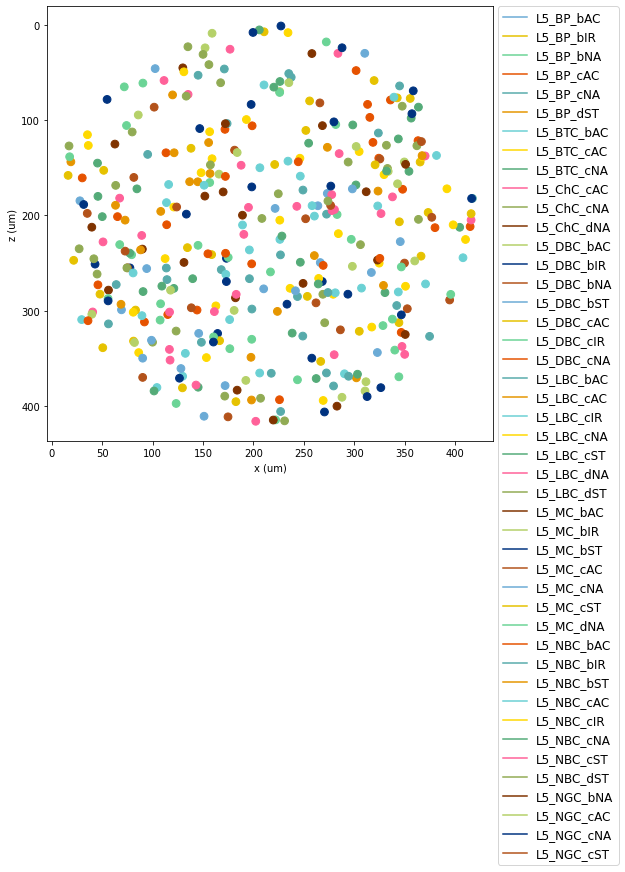

In [53]:
sim.analysis.plot2Dnet(include=cfg.allpops,view='xz', showConns=False, 
                               popColors=None, tagsFile=None, figSize=(8, 8), fontSize=12, saveData=None, 
                               saveFig=None, showFig=True, lineWidth=0.1);

In [54]:
# Define cell type colors based on specific keywords in the cell type labels
colors = {}
for cell_type, label in cfg.cellLabel.items():
    if any(keyword in label for keyword in ['PC', 'SS', 'SP', 'TTPC1', 'TTPC2', 'STPC', 'UTPC']):
        colors[cell_type] = 'purple'
    elif any(keyword in label for keyword in ['DBC', 'MC', 'BP', 'BTC', 'SMC', 'SBC']):
        colors[cell_type] = 'blue'
    elif any(keyword in label for keyword in ['ChC', 'LBC', 'NBC']):
        colors[cell_type] = 'orange'
    else:
        # Assign a default color if the cell type label does not match any specified keywords
        colors[cell_type] = 'black'  # You can replace 'default_color' with the color of your choice

# Output the final colors assigned to each cell type based on the keyword matching
# for cell_type, color in colors.items():
#     print(f"{cell_type}: {color}")


In [55]:
# Define a function to convert color names to RGB tuples
def color_name_to_rgb(color_name):
    color_mapping = {
        'blue': (0, 0, 255),
        'orange': (255, 165, 0),
        'purple': (128, 0, 128)
        # Add more color mappings as needed
    }
    return color_mapping.get(color_name, (0, 0, 0));  # Default to black if color not found

# Convert color names to RGB tuples
colors_rgb = {cell_name: color_name_to_rgb(color) for cell_name, color in colors.items()};

# Plot raster with custom group colors
sim.analysis.iplotRaster(
    include=['allCells'], 
    timeRange=[0, cfg.duration], 
    orderBy='y', 
    orderInverse=True, 
    lw=1, 
    marker='o', 
    markerSize=10, 
    dpi=300,
    popRates=True, 
    saveFig=True, 
    showFig=True,
    saveData=False,
    popColors=colors_rgb  # Use the dynamically assigned cell type colors
);


Plotting interactive raster ...


In [56]:
# help(sim.analysis.plotRaster)

## Raster and traces

Preparing spike data...
Saving data as ../runSubNets/L5_ImPhysX2.2_Cai1e-12_Sk0/L5_ImPhysX2.2_Cai1e-12_Sk0_spike_data.pkl ... 
Plotting raster...
Saving data as ../runSubNets/L5_ImPhysX2.2_Cai1e-12_Sk0/L5_ImPhysX2.2_Cai1e-12_Sk0_data.pkl ... 


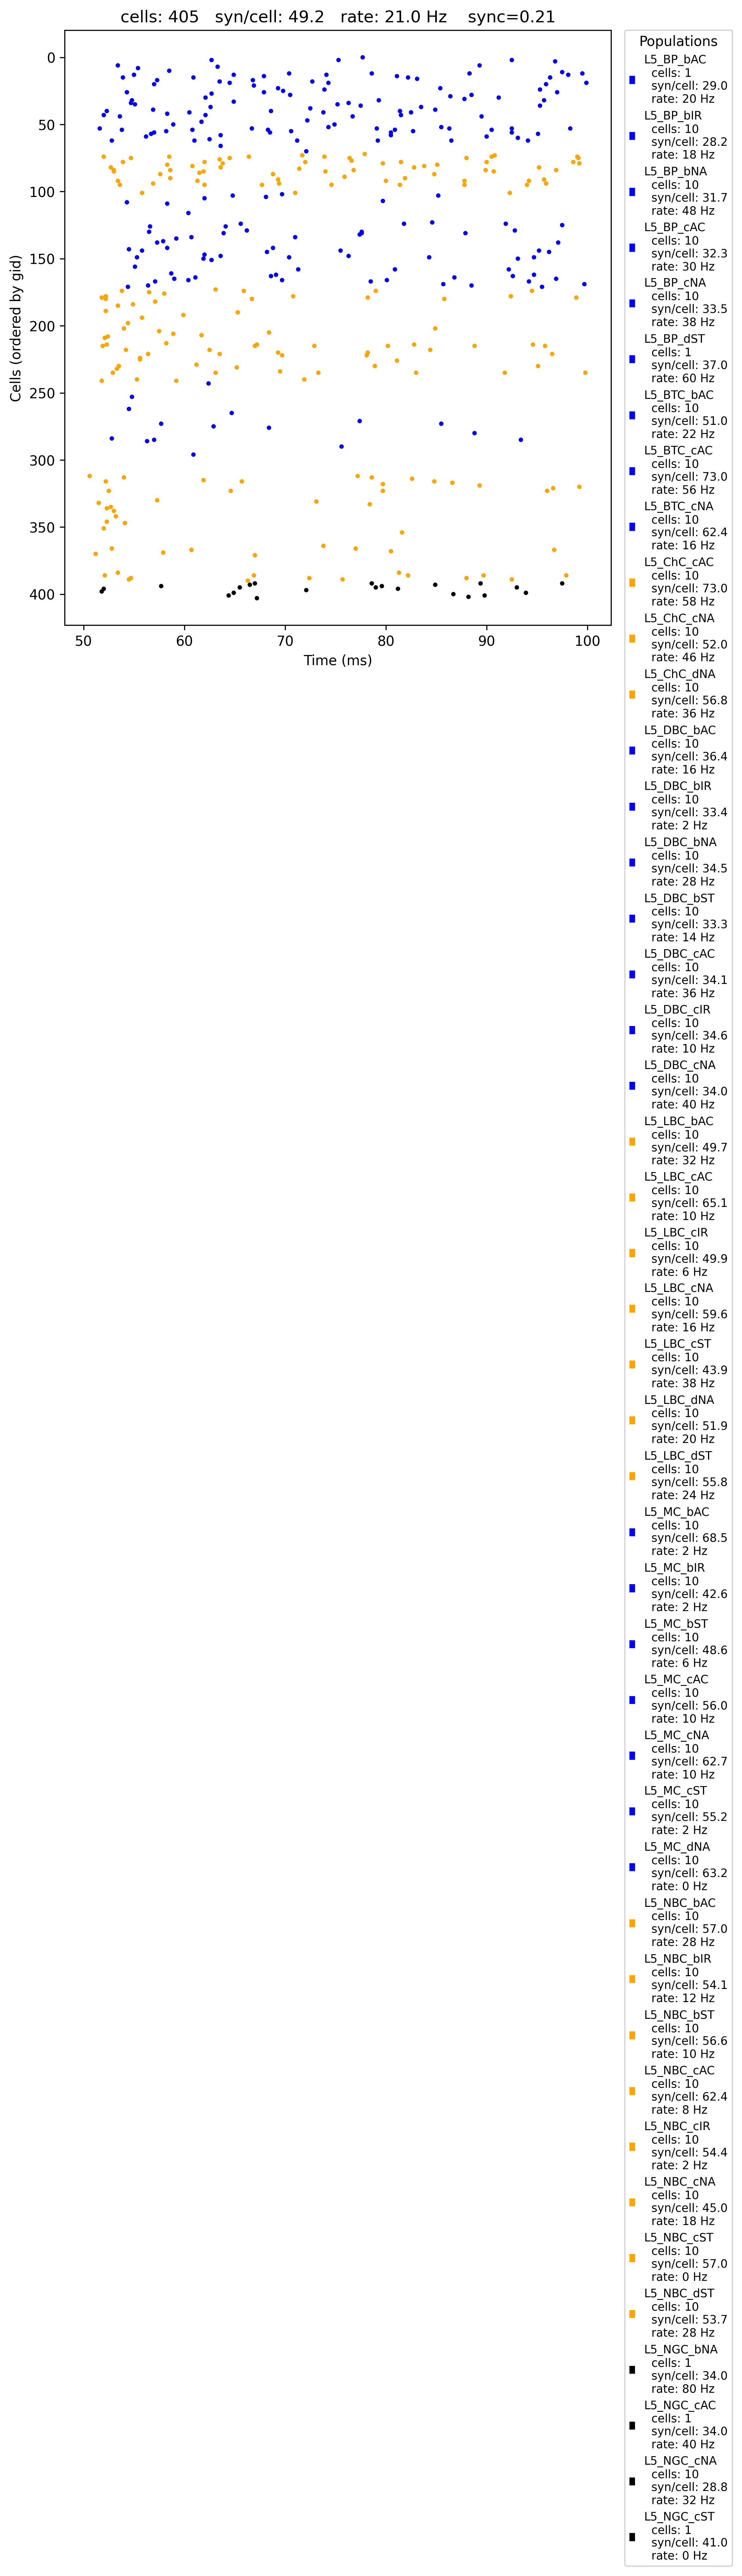

In [57]:
# Evoked PostStim activity
sim.analysis.plotRaster(include=['eachPop'], timeRange=[50,100], orderBy='gid',  orderInverse=True, figsize = (12,4),  lw=1, marker='o', markerSize=15, popColors=colors, dpi=300, popRates=True, spikeHist=True, spikeHistBin=5, saveData = True, saveFig=True, showFig=False);

Preparing spike data...
Saving data as ../runSubNets/L5_ImPhysX2.2_Cai1e-12_Sk0/L5_ImPhysX2.2_Cai1e-12_Sk0_spike_data.pkl ... 
Plotting raster...
Saving data as ../runSubNets/L5_ImPhysX2.2_Cai1e-12_Sk0/L5_ImPhysX2.2_Cai1e-12_Sk0_data.pkl ... 


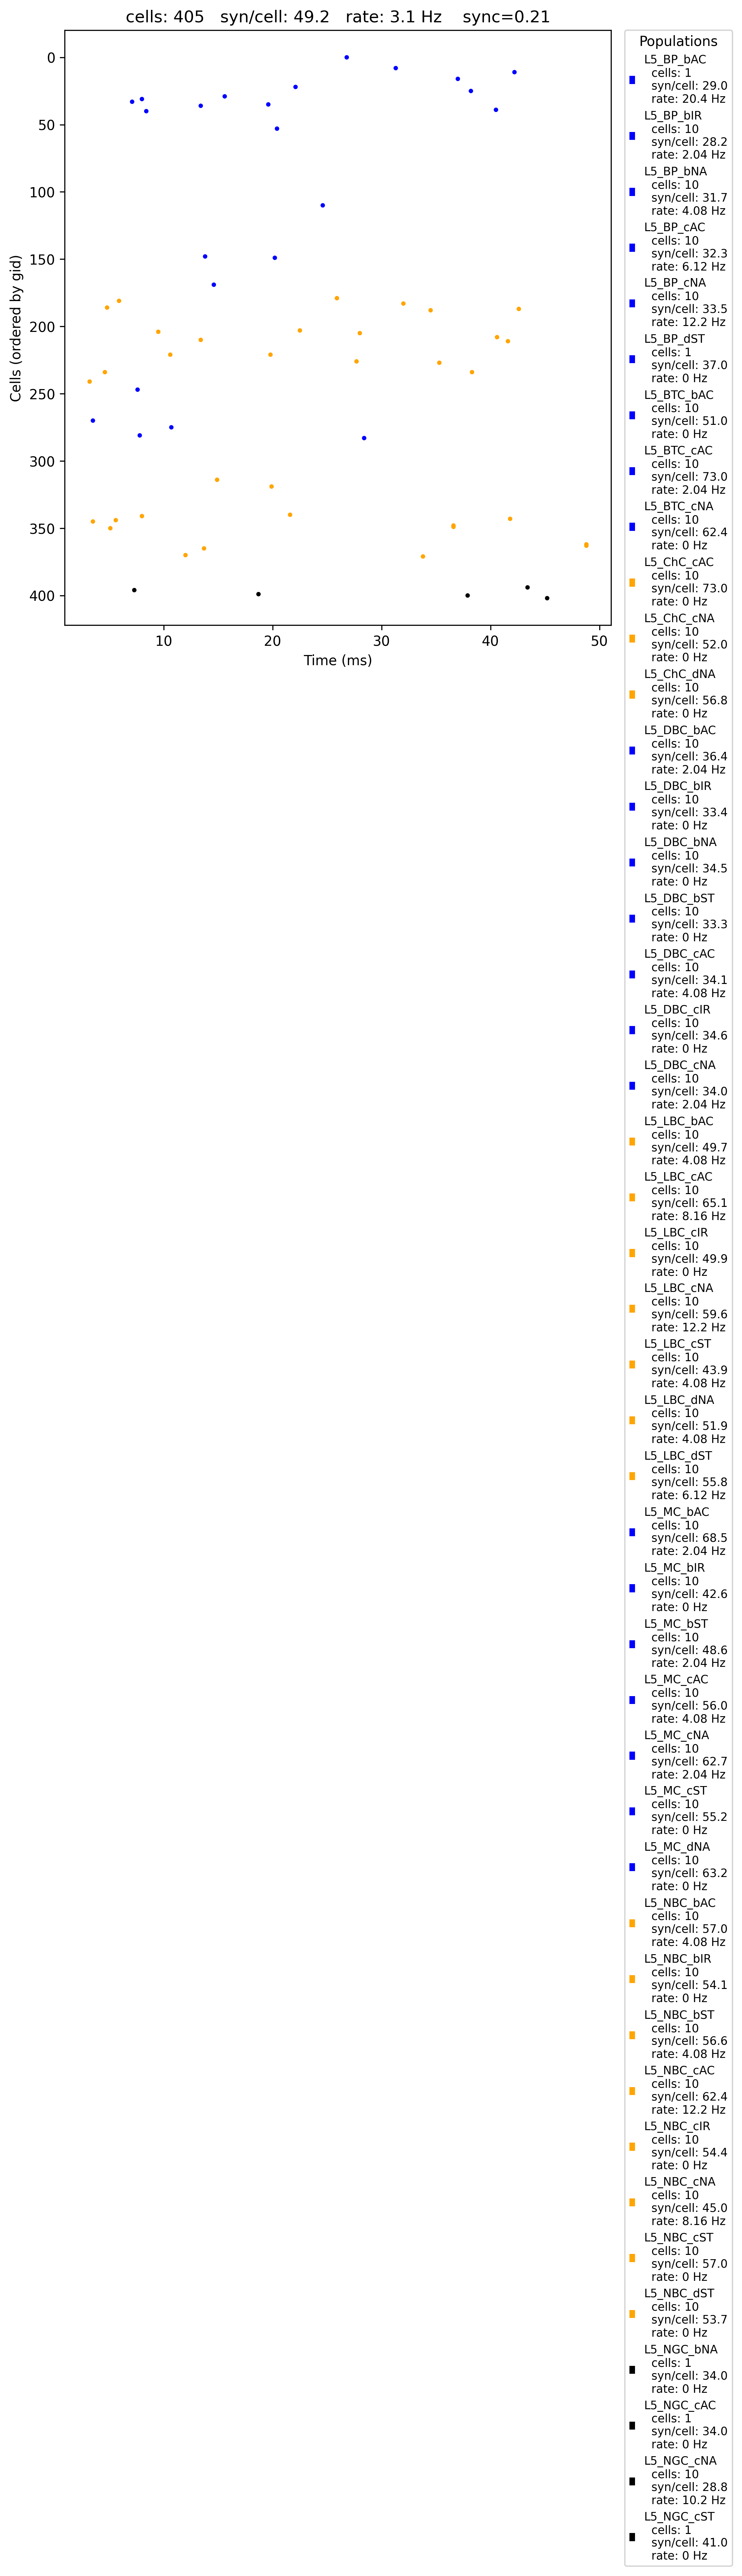

In [58]:
#Spont activity: preStim
sim.analysis.plotRaster(include=['eachPop'], timeRange=[0,49], orderBy='gid',  orderInverse=True, figsize = (12,4),  lw=1, marker='o', markerSize=15, popColors=colors, dpi=300, popRates=True, spikeHist=True, spikeHistBin=5, saveData = True, saveFig=True, showFig=False);

Preparing spike data...
Plotting raster...


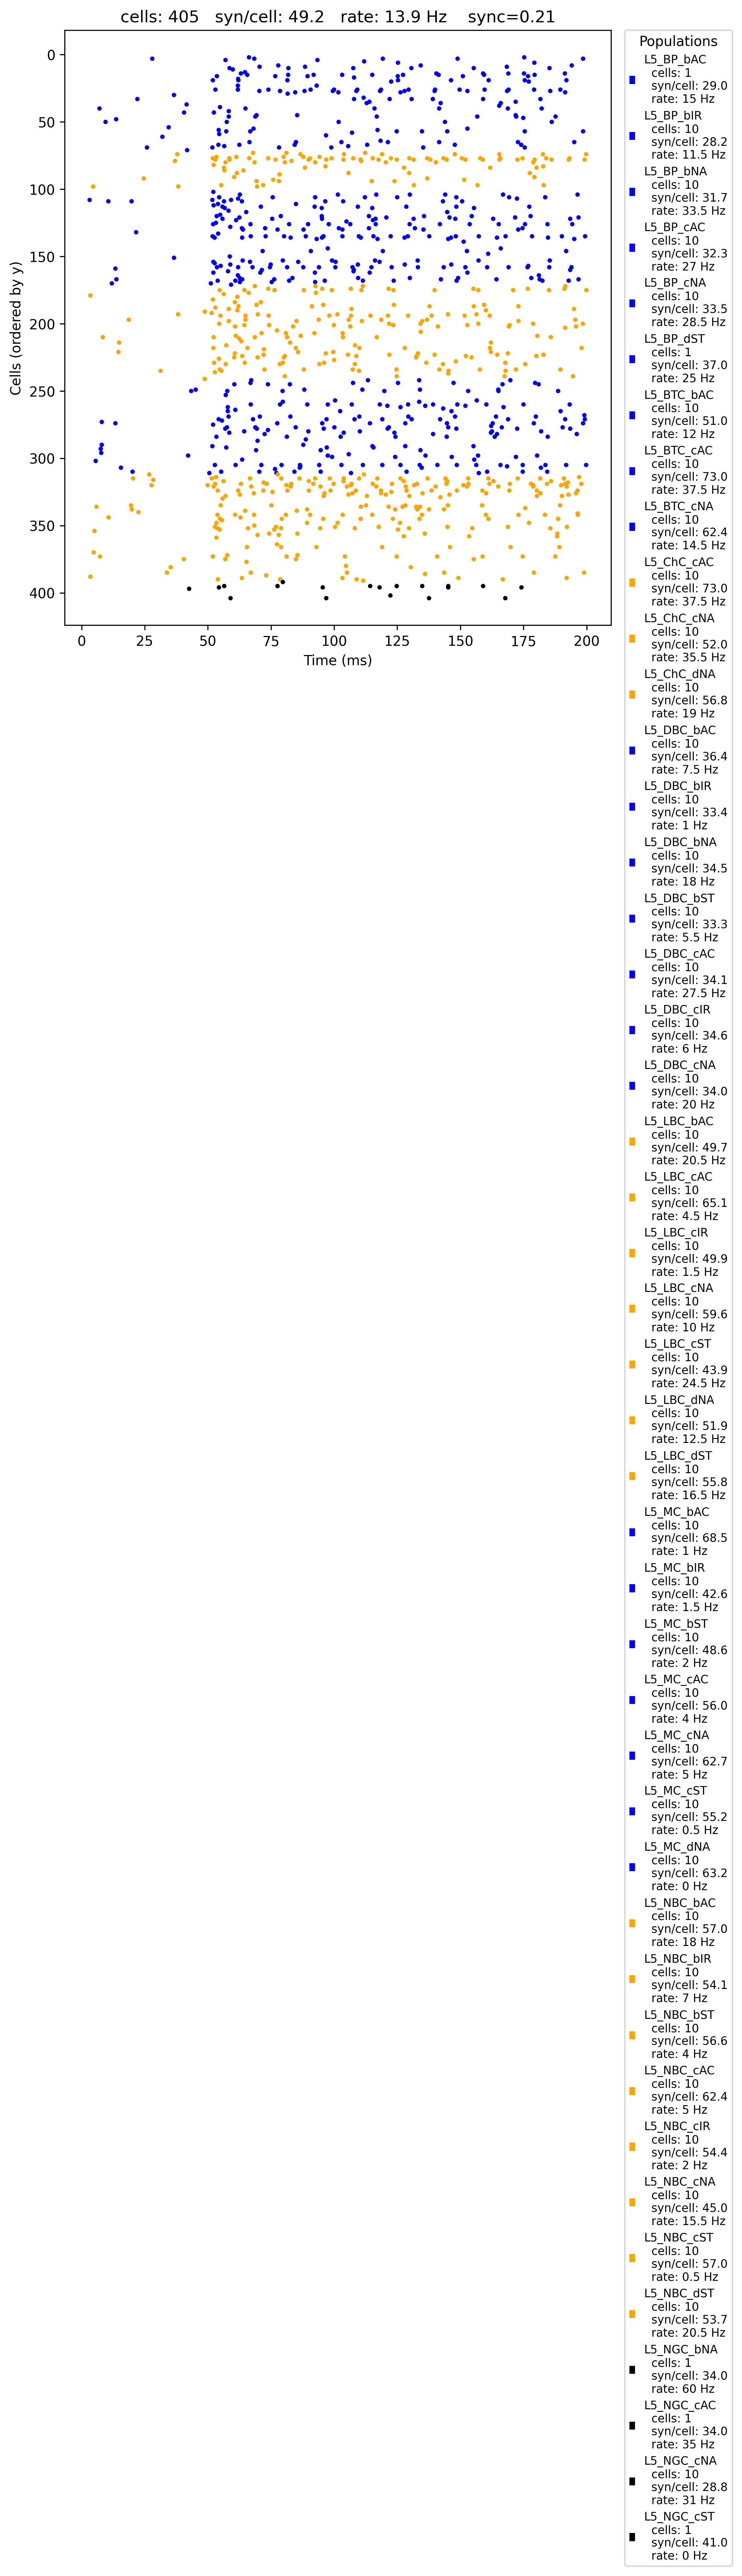

In [59]:
#Full raster
sim.analysis.plotRaster(include=['eachPop'], timeRange=[0,200], orderBy='y',  orderInverse=True, figsize = (12,4),  lw=1, marker='o', markerSize=15, popColors=colors, dpi=300, popRates=True, spikeHist=True, spikeHistBin=5, saveData = False, saveFig=True, showFig=False);

In [60]:
sa = sim.analysis

In [61]:
help(sim.analysis.plotSpikeHist)

Help on function plotSpikeHist in module netpyne.analysis.mapping:

plotSpikeHist(include=['eachPop', 'allCells'], timeRange=None, binSize=5, graphType='line', measure='rate', norm=False, smooth=None, filtFreq=None, filtOrder=3, axis=True, popColors=None, figSize=(10, 8), dpi=100, saveData=None, saveFig=None, showFig=True, **kwargs)



Preparing spike data...
Plotting spike histogram...


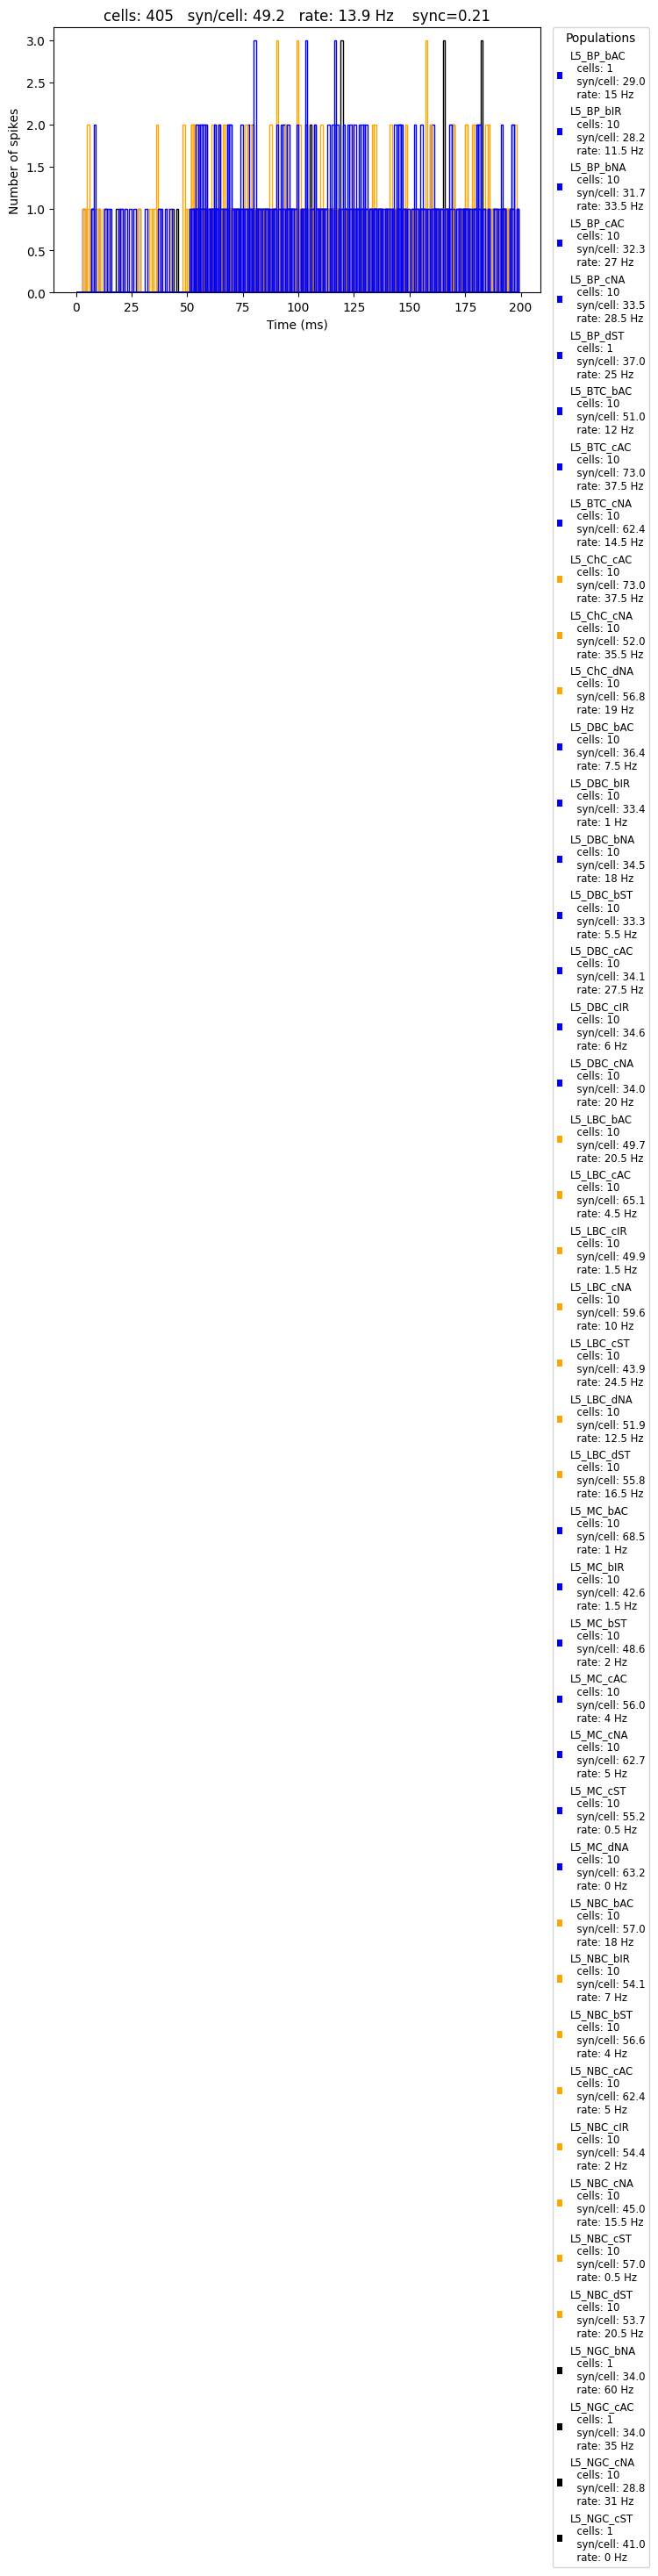

In [62]:
sa.plotSpikeHist(include=['eachPop'], binSize=1, measure='count', figSize=(10, 4), ylim=[0, 85], saveFig=True, popColors = colors);

In [63]:
# data['statData'][data['include'].index('L23_NGC_bNA')]

In [64]:
subPopLabels

['L5_BP', 'L5_BTC', 'L5_ChC', 'L5_DBC', 'L5_LBC', 'L5_MC', 'L5_NBC', 'L5_NGC']

In [65]:
# fig, data = sa.plotSpikeStats(include=['eachPop'], statDataIn={}, timeRange=[0,49], graphType='boxplot', includeRate=True, stats=['rate'], bins=50, histlogy=False, histlogx=False, histmin=0.1, density=False, includeRate0=True, legendLabels=None, normfit=True, histShading=False, xlim=[0, 120], popColors=colors, figSize=(12, 8), fontSize=12, dpi=100, saveData=None, saveFig=True, showFig=True);


In [66]:
# fig1, data1 = sa.plotSpikeStats(include=['eachPop'], statDataIn={}, timeRange=[50,70], graphType='boxplot', includeRate=True, stats=['rate'], bins=50, histlogy=False, histlogx=False, histmin=0.1, density=False, includeRate0=True, legendLabels=None, normfit=True, histShading=False, xlim=[0, 120], popColors=colors, figSize=(12, 8), fontSize=12, dpi=100, saveData=None, saveFig=True, showFig=True);


In [67]:
# cfg.analysis.plotRaster(include=['allNetStims'], timeRange=[0,cfg.duration], orderBy='y', orderInverse=True, labels='legend',  lw=5, marker='o', markerSize=28, figSize=(20, 10), fontSize=20, dpi=300,  saveFig=False, showFig=False);

In [68]:
# for metype in cfg.cellParamLabels:
#     if cfg.popLabel[metype] in subPopLabels:
#         print(metype,cfg.cellNumber[metype],cfg.popLabel[metype],cfg.popNumber[cfg.popLabel[metype]])     

# traces = [(mtype, [i for i in range(0,cfg.popNumber[mtype],int(cfg.popNumber[mtype]/4.5))]) for mtype in subPopLabels]
# traces

In [69]:
# for pops in cfg.cellParamLabels:
#     print('\n\n',pops,'  N =',cfg.cellNumber[pops])
#     sim.analysis.plotTraces(include=[pops], timeRange=[0,cfg.duration], overlay=True, oneFigPer='trace', subtitles=False, legend=False, ylim=[-110,50], axis=False, scaleBarLoc=3, figSize=(18, 4), fontSize=15, saveFig=cfg.saveFolder +'/'+cfg.simLabel +'_'+pops+ '_Vt.png');

In [70]:
# sa.plot2Dnet(figSize=(10, 10), saveFig=True);

In [71]:
# sa.plotConn(groupBy='cell', feature='numConns', orderBy='y');

## Load Pkl file that has spont and evoked FRs

In [72]:
with open('../runSubNets/' + cfg.simLabel + '/' + cfg.simLabel + '_spike_datae.pkl', 'rb') as fileObj: EvokedspikeData = pickle.load(fileObj);
with open('../runSubNets/' + cfg.simLabel + '/' + cfg.simLabel + '_spike_datas.pkl', 'rb') as fileObj: SpontspikeData = pickle.load(fileObj)

In [73]:
EvokedspikeData = EvokedspikeData ['legendLabels'];
SpontspikeData = SpontspikeData ['legendLabels'];

## Population-wise boxplots - Spontaneous activity (from data - 0ms to 49ms)


In [74]:
# desired_order = ['L23_BP', 'L23_BTC', 'L23_MC', 'L23_DBC', 'L23_LBC', 'L23_ChC', 'L23_NBC', 'L23_NGC'] 
# L4: 'L4_BP', 'L4_BTC', 'L4_MC', 'L4_DBC', 'L4_LBC', 'L4_ChC', 'L4_NBC', 'L4_NGC'
#Exc: 'L23_PC', 'L4_PC' , 'L4_SP' , 'L4_SS', 'L5_STPC' , 'L5_TTPC1' , 'L5_TTPC2', 'L5_UTPC'
desired_order = ['L5_BP', 'L5_BTC', 'L5_MC', 'L5_DBC', 'L5_LBC', 'L5_ChC', 'L5_NBC', 'L5_NGC']
color_mapping = {}
for label in desired_order:
    if any(keyword in label for keyword in ['_PC', '_SS', '_ST' , '_SP', '_TTPC1', '_TTPC2', '_STPC', '_UTPC']):
        color_mapping[label] = 'pink'
    elif any(keyword in label for keyword in ['_ChC', '_LBC', '_NBC']):
        color_mapping[label] = 'orange'
    elif any(keyword in label for keyword in ['_BP', '_BTC', '_MC', '_DBC', '_SBC', '_SMC']):
        color_mapping[label] = 'navy'
    else:
        # Assign a default color
        color_mapping[label] = 'black'


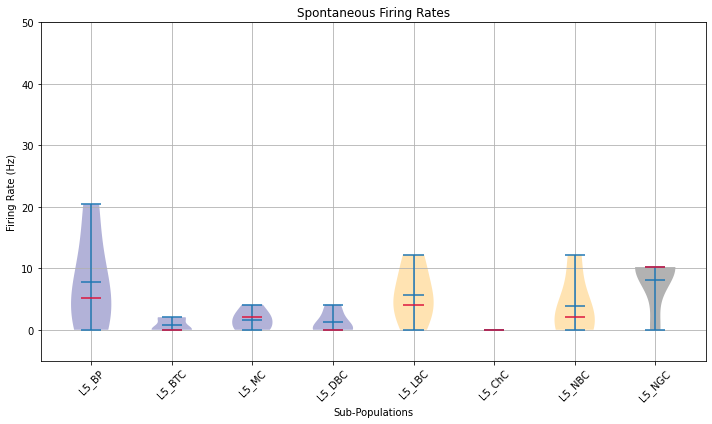

In [75]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use('Agg') 
#subPopLabels = ['L23_BP', 'L23_BTC', 'L23_ChC', 'L23_DBC', 'L23_LBC', 'L23_MC', 'L23_NBC', 'L23_NGC']
subPopLabels = ['L5_BP', 'L5_BTC', 'L5_ChC', 'L5_DBC', 'L5_LBC', 'L5_MC', 'L5_NBC', 'L5_NGC']
# 'L4_BP', 'L4_BTC', 'L4_ChC', 'L4_DBC', 'L4_LBC', 'L4_MC', 'L4_NBC', 'L4_NGC'
# 'L23_BP', 'L23_BTC', 'L23_ChC', 'L23_DBC', 'L23_LBC', 'L23_MC', 'L23_NBC', 'L23_NGC', 'L23_PC'
#'L4_BP', 'L4_BTC', 'L4_DBC',  'L4_MC', 'L4_LBC', 'L4_ChC', 'L4_NBC', 'L4_PC', 'L4_SP', 'L4_SS'
#'L5_BP', 'L5_BTC', 'L5_ChC', 'L5_DBC', 'L5_LBC', 'L5_MC', 'L5_NBC', 'L5_NGC', 'L5_SBC', 'L5_TTPC1', 'L5_TTPC2', 'L5_STPC', 'L5_UTPC'
# Initialize a dictionary to store the average firing rates and boxplot measures for each population
firing_rates = {}
num_cells = {}

# Parse the data
for entry in SpontspikeData:
    parts = entry.split('\n')
    subpop_label = parts[0]  # Extract the subpopulation label correctly
    rate = float(parts[-1].split(': ')[1].split()[0])  # Extract the firing rate
    cells = int(parts[1].split(': ')[1])  # Extract the number of cells
    # Store firing rate and number of cells for the subpopulation
    if subpop_label not in firing_rates:
        firing_rates[subpop_label] = []
        num_cells[subpop_label] = []
    firing_rates[subpop_label].extend([rate] * cells)  # Replicate firing rate for each cell
    num_cells[subpop_label].extend([cells] * cells)  # Record the number of cells

# Initialize dictionaries to store combined firing rates and number of cells for each main population
combined_firing_rates = {label: [] for label in desired_order}
num_cells = {label: [] for label in desired_order}

# Combine firing rates and number of cells for each main population
for subpop_label, rates in firing_rates.items():
    for main_label in desired_order:
        if main_label in subpop_label:
            combined_firing_rates[main_label].extend(rates)
            num_cells[main_label].append(len(rates))

# Create violin plot data
combinedFR_data = [combined_firing_rates[label] for label in desired_order]
population_stats = {}

# Calculate summary statistics for each subpopulation
for subPopLabel in desired_order:
    firing_rates_subpop = combined_firing_rates[subPopLabel]
    min_val = np.min(firing_rates_subpop)
    q1 = np.percentile(firing_rates_subpop, 25)
    median = np.percentile(firing_rates_subpop, 50)
    q3 = np.percentile(firing_rates_subpop,75)
    max_val = np.max(firing_rates_subpop)
    
    # Store the summary statistics in the dictionary
    population_stats[subPopLabel] = {
        'min_val': min_val,
        'q1': q1,
        'median': median,
        'q3': q3,
        'max_val': max_val
    }
violin_data = [[stats['min_val'], stats['q1'], stats['median'], stats['q3'], stats['max_val']] for stats in population_stats.values()]
    
# Create violin plots
plt.figure(figsize=(10, 6))
violins = plt.violinplot(violin_data, showmeans=True, showmedians=True, showextrema=True)

# # Calculate and plot whiskers
# for i, stats in enumerate(population_stats.values()):
#     q1 = stats['q1']
#     q3 = stats['q3']
#     iqr = q3 - q1
#     upper_whisker = q3 + 1.5 * iqr
#     lower_whisker = q1 - 1.5 * iqr
#     plt.plot([i + 1, i + 1], [lower_whisker, upper_whisker], color='grey', linewidth=3)

plt.xticks(range(1, len(desired_order) + 1), desired_order, rotation=45)
plt.title('Spontaneous Firing Rates')
plt.xlabel('Sub-Populations')
plt.ylabel('Firing Rate (Hz)')
plt.ylim([-5, 50])   
for pc, label in zip(violins['bodies'], desired_order):
    pc.set_facecolor(color_mapping[label])

# for partname in violins.keys():
#     if partname == 'bodies':
#         continue
#     violins[partname].set_color('grey')  # Set color of other parts to black
violins['cmedians'].set_color('crimson')  

plt.grid(True)
plt.tight_layout()
plt.show()


plt.savefig('../runSubNets/' + cfg.simLabel + '/SpontAllSubPops.svg', format='svg')


## Population-wise boxplots - Evoked activity(from data1 - 50ms to 100ms)


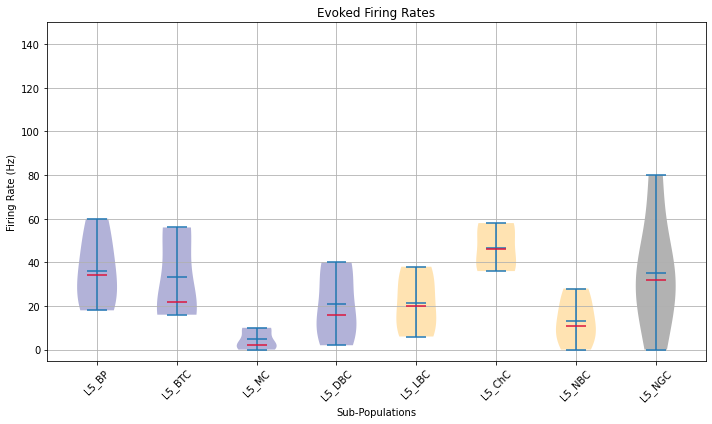

In [76]:
# Define the desired order of subpopulation labels
desired_order = ['L5_BP', 'L5_BTC', 'L5_MC', 'L5_DBC', 'L5_LBC', 'L5_ChC', 'L5_NBC', 'L5_NGC']
#L4_BP', 'L4_BTC', 'L4_DBC',  'L4_MC', 'L4_LBC', 'L4_ChC', 'L4_NBC', 'L4_PC',  'L4_SP', 'L4_SS
# Define colors for each category of subpopulation labels
# subPopLabels = ['L23_BP', 'L23_BTC', 'L23_ChC', 'L23_DBC', 'L23_LBC', 'L23_MC', 'L23_NBC', 'L23_NGC']
# desired_order = ['L23_BP', 'L23_BTC', 'L23_MC', 'L23_DBC', 'L23_LBC', 'L23_ChC', 'L23_NBC', 'L23_NGC']
# desired_order = ['L23_EXC', 'L4_EXC', 'L5_EXC']
# subPopLabels = ['L23_PC', 'L4_PC' , 'L4_SP' , 'L4_SS', 'L5_STPC' , 'L5_TTPC1' , 'L5_TTPC2', 'L5_UTPC' ]
# Initialize dictionaries to store firing rates and number of cells for each subpopulation
firing_rates = {}
num_cells = {}

# Parse the data
for entry in EvokedspikeData:
    parts = entry.split('\n')
    subpop_label = parts[0]  # Extract the subpopulation label correctly
    rate = float(parts[-1].split(': ')[1].split()[0])  # Extract the firing rate
    cells = int(parts[1].split(': ')[1])  # Extract the number of cells
    # Store firing rate and number of cells for the subpopulation
    if subpop_label not in firing_rates:
        firing_rates[subpop_label] = []
        num_cells[subpop_label] = []
    firing_rates[subpop_label].extend([rate] * cells)  # Replicate firing rate for each cell
    num_cells[subpop_label].extend([cells] * cells)  # Record the number of cells

# Initialize dictionaries to store combined firing rates and number of cells for each main population
combined_firing_rates2 = {label: [] for label in desired_order}
num_cells = {label: [] for label in desired_order}

# Combine firing rates and number of cells for each main population
for subpop_label, rates in firing_rates.items():
    for main_label in desired_order:
        if main_label in subpop_label:
            combined_firing_rates2[main_label].extend(rates)
            num_cells[main_label].append(len(rates))

# Create violin plot data
combinedFR_data = [combined_firing_rates2[label] for label in desired_order]
population_stats = {}

# Calculate summary statistics for each subpopulation
for subPopLabel in desired_order:
    firing_rates_subpop = combined_firing_rates2[subPopLabel]
    min_val = np.min(firing_rates_subpop)
    q1 = np.percentile(firing_rates_subpop, 25)
    median = np.percentile(firing_rates_subpop, 50)
    q3 = np.percentile(firing_rates_subpop,75)
    max_val = np.max(firing_rates_subpop)
    
    # Store the summary statistics in the dictionary
    population_stats[subPopLabel] = {
        'min_val': min_val,
        'q1': q1,
        'median': median,
        'q3': q3,
        'max_val': max_val
    }
violin_data = [[stats['min_val'], stats['q1'], stats['median'], stats['q3'], stats['max_val']] for stats in population_stats.values()]
    
# Create violin plots
plt.figure(figsize=(10, 6))
violins = plt.violinplot(violin_data, showmeans=True, showmedians=True, showextrema=True)

# # Calculate and plot whiskers
# for i, stats in enumerate(population_stats.values()):
#     q1 = stats['q1']
#     q3 = stats['q3']
#     iqr = q3 - q1
#     upper_whisker = q3 + 1.5 * iqr
#     lower_whisker = q1 - 1.5 * iqr
#     plt.plot([i + 1, i + 1], [lower_whisker, upper_whisker], color='grey', linewidth=3)

plt.xticks(range(1, len(desired_order) + 1), desired_order, rotation=45)
plt.title('Evoked Firing Rates')
plt.xlabel('Sub-Populations')
plt.ylabel('Firing Rate (Hz)')
plt.ylim([-5, 150])  
for pc, label in zip(violins['bodies'], desired_order):
    pc.set_facecolor(color_mapping[label])

# for partname in violins.keys():
#     if partname == 'bodies':
#         continue
#     violins[partname].set_color('grey')  # Set color of other parts to black
violins['cmedians'].set_color('crimson')  

plt.grid(True)
plt.tight_layout()
plt.show()


plt.savefig('../runSubNets/' + cfg.simLabel + '/EvokedAllSubPops.svg', format='svg')


## Export spont and Evoked FRs for all cells

In [77]:
import csv
# Save data1 as a CSV file
csv_file_path = '../runSubNets/' + cfg.simLabel + '/EvokedAllCellsFR.csv'

# Write combined_firing_rates2 to a CSV file
with open(csv_file_path, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    
    # Write each subpopulation and its firing rates
    for subpopulation, firing_rates in combined_firing_rates2.items():
        # Write subpopulation name in the first column
        writer.writerow([subpopulation] + firing_rates)

In [78]:
# Save data as a CSV file for Spontaneous PreStim FRs
csv_file_path = '../runSubNets/' + cfg.simLabel + '/SpontAllCellsFR.csv'
# Write combined_firing_rates2 to a CSV file
with open(csv_file_path, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    
    # Write each subpopulation and its firing rates
    for subpopulation, firing_rates in combined_firing_rates.items():
        # Write subpopulation name in the first column
        writer.writerow([subpopulation] + firing_rates)


## Extract y-locations of all Cells in um

Plotting 2D representation of network cell locations and connections...


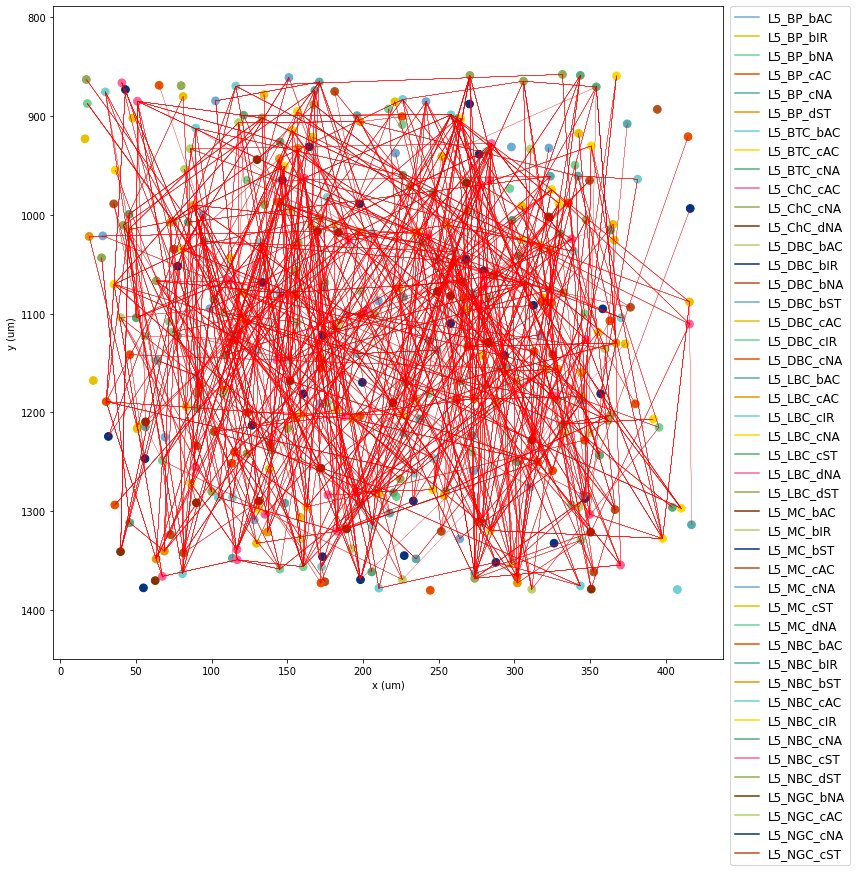

In [79]:
fig4, data4 = sim.analysis.plot2Dnet(include=['allCells'], view='xy', showConns=True, popColors=None, tagsFile=None, figSize=(12, 12), fontSize=12, saveData=False, saveFig=None, showFig=True, lineWidth=0.1)



In [ ]:
data4['posY']

## Calculate the Modulation Indices by loading Evoked FRs in  all 3 conditions 

In [ ]:
import csv
import os

# Function to load firing rates from a CSV file
def load_firing_rates(file_path):
    firing_rates = []
    with open(file_path, 'r') as csvfile:
        reader = csv.reader(csvfile)
        next(reader)  # Skip header row
        for row in reader:
            population_name = row[0]
            rates = [float(rate) for rate in row[1:]]
            firing_rates.append((population_name, rates))
    return firing_rates

# File paths for the CSV files
folder_path = '../runSubNets/' 
evoked_control_path = os.path.join(folder_path, 'EvokedControl.csv')
evoked_m1_activation_path = os.path.join(folder_path, 'EvokedM1Activation.csv')
evoked_m1_inhibition_path = os.path.join(folder_path, 'EvokedM1Inhibition.csv')

# Load firing rates from CSV files
control_firing_rates = load_firing_rates(evoked_control_path)
m1_activation_firing_rates = load_firing_rates(evoked_m1_activation_path)
m1_inhibition_firing_rates = load_firing_rates(evoked_m1_inhibition_path)

# Calculate modulation indices
m1_activation_modulation_indices = {}
m1_inhibition_modulation_indices = {}

# # Accumulate firing rates for each population into a single array
control_firing_rates_accumulated = []
control_CellPop_Names_accumulated = []
m1_activation_firing_rates_accumulated = []
m1_inhibition_firing_rates_accumulated = []

# Filter out non-zero firing rates and accumulate for matching neurons
for population_name, rates in control_firing_rates:
    non_zero_rates = [rate for rate in rates if rate != 0.0]
    if non_zero_rates:
        control_firing_rates_accumulated.extend(non_zero_rates)
        control_CellPop_Names_accumulated.extend([population_name] * len(non_zero_rates))
        for pop_name, firing_rates in m1_activation_firing_rates:
            if pop_name == population_name:
                m1_activation_firing_rates_accumulated.extend(firing_rates)
                break  # Exit loop once the matching population is found
        for pop_name, firing_rates in m1_inhibition_firing_rates:
            if pop_name == population_name:
                m1_inhibition_firing_rates_accumulated.extend(firing_rates)
                break  # Exit loop once the matching population is found

# Ensure both accumulated firing rates arrays have the same length
min_len = min(len(control_firing_rates_accumulated), len(m1_activation_firing_rates_accumulated))
control_firing_rates_accumulated = control_firing_rates_accumulated[:min_len]
control_CellPop_Names_accumulated = control_CellPop_Names_accumulated[:min_len]
m1_activation_firing_rates_accumulated = m1_activation_firing_rates_accumulated[:min_len]
m1_inhibition_firing_rates_accumulated = m1_inhibition_firing_rates_accumulated[:min_len]

# Convert lists to NumPy arrays
control_firing_rates_accumulated = np.array(control_firing_rates_accumulated)
control_CellPop_Names_accumulated = np.array(control_CellPop_Names_accumulated)
m1_activation_firing_rates_accumulated = np.array(m1_activation_firing_rates_accumulated)
m1_inhibition_firing_rates_accumulated = np.array(m1_inhibition_firing_rates_accumulated)

# Calculate modulation indices for each cell
m1_activation_modulation_indices = (m1_activation_firing_rates_accumulated - control_firing_rates_accumulated) / \
                                   (m1_activation_firing_rates_accumulated + control_firing_rates_accumulated)

m1_inhibition_modulation_indices = (m1_inhibition_firing_rates_accumulated - control_firing_rates_accumulated) / \
                                    (m1_inhibition_firing_rates_accumulated + control_firing_rates_accumulated)


In [ ]:
## Old code for calculating all MIs for all neurons even that have a zero FR
# Load firing rates from CSV files
control_firing_rates = load_firing_rates(evoked_control_path)
m1_activation_firing_rates = load_firing_rates(evoked_m1_activation_path)
m1_inhibition_firing_rates = load_firing_rates(evoked_m1_inhibition_path)

# Calculate modulation indices
m1_activation_modulation_indices = {}
m1_inhibition_modulation_indices = {}

# Accumulate firing rates for each population into a single array
control_firing_rates_accumulated = np.concatenate([rates for _, rates in control_firing_rates]).flatten()
control_CellPop_Names_accumulated = np.concatenate([[population_name] * len(rates) for population_name, rates in control_firing_rates])
m1_activation_firing_rates_accumulated = np.concatenate([rates for _, rates in m1_activation_firing_rates]).flatten()
m1_inhibition_firing_rates_accumulated = np.concatenate([rates for _, rates in m1_inhibition_firing_rates]).flatten()

# Calculate modulation indices for each cell
m1_activation_modulation_indices = (m1_activation_firing_rates_accumulated - control_firing_rates_accumulated) / \
                                   (m1_activation_firing_rates_accumulated + control_firing_rates_accumulated)

m1_inhibition_modulation_indices = (m1_inhibition_firing_rates_accumulated - control_firing_rates_accumulated) / \
                                    (m1_inhibition_firing_rates_accumulated + control_firing_rates_accumulated)

In [ ]:
control_CellPop_Names_accumulated

In [ ]:
# Define the file path for saving the Modulation indices CSV
csv_file_path = '../runSubNets/ModulationIndices.csv'

# Combine the modulation indices into a single list for each column
combined_modulation_indices = list(zip(m1_activation_modulation_indices, m1_inhibition_modulation_indices))

# Save the modulation indices as a CSV file
with open(csv_file_path, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    
    # Write header row
    writer.writerow(['M1_Activation_Modulation_Index', 'M1_Inhibition_Modulation_Index'])
    
    # Write data rows
    writer.writerows(combined_modulation_indices)


In [ ]:
# Define the file path for saving the Modulation indices CSV
csv_file_path = '../runSubNets/BaselineFiring.csv'

# Combine the modulation indices into a single list for each column
baseline_firings = list(zip(control_firing_rates_accumulated))

# Save the modulation indices as a CSV file
with open(csv_file_path, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    # Write data rows
    writer.writerows(baseline_firings)
    


In [ ]:
control_population_names_path = os.path.join(folder_path, 'ControlPopulationNames.csv')

# Save control_CellPop_Names_accumulated as a CSV file
np.savetxt(control_population_names_path, control_CellPop_Names_accumulated, delimiter=',', fmt='%s')